# Projet 6 : Classification automatique des biens de consommation

## Mission 1 - Etudier la faisabilité d'un moteur de classification d'articles

### Problématique :
- Je suis Data Scientist au sein de l'entreprise "Place de marché", qui souhaite lancer une marketplace e-commerce.
- Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description. Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l'instant très petit.
- Pour rendre l'expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d'attribution de la catégorie.
<br>
<br>
- Missions :
> Etudier la faisabilité d'un moteur de classification automatique des articles en différentes catégories, en utilisant leur image et leur description.

In [1]:
# pip install numpy==1.26.4

In [2]:
# pip install keras

In [3]:
# pip install tensorflow

In [2]:
# pip install --upgrade tensorflow

In [ ]:
# pip install opencv-python

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
import seaborn as sns
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score,adjusted_rand_score,confusion_matrix,classification_report
from sklearn.cluster import KMeans,MiniBatchKMeans

from collections import Counter
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.probability import FreqDist

import gensim
from gensim.models import Word2Vec

# Using the vgg16 model as a feature extraction model
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions,VGG16
from keras import Input,Model
import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer, BertModel
import torch

from matplotlib.image import imread
import cv2

from unidecode import unidecode
import re
import string
from wordcloud import WordCloud, STOPWORDS
import IPython
from PIL import Image
import random
import os
os.environ["OMP_NUM_THREADS"] = "5"
from os import listdir

# I. Exploration des données textuelles

In [2]:
# Import  data
text_data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv') 
text_data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [3]:
# Data info
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
# Rate of nan values per feature
(((text_data.isna().sum()/text_data.shape[0])*100).round(2)).sort_values(ascending= False)

brand                      32.19
retail_price                0.10
discounted_price            0.10
product_specifications      0.10
uniq_id                     0.00
crawl_timestamp             0.00
product_url                 0.00
product_name                0.00
product_category_tree       0.00
pid                         0.00
image                       0.00
is_FK_Advantage_product     0.00
description                 0.00
product_rating              0.00
overall_rating              0.00
dtype: float64

**Déplication des étiquettes de la colonne « product_category_tree »**

In [5]:
# Raw labels
text_data.product_category_tree.value_counts()

["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         22
["Home Furnishing >> Bath Linen >> Towels"]                                           19
                                                                                      ..
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]     1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]           1
["Watches >> Wrist Watches >> Petrol Wrist Watches"]                                   1
Name: product_categor

In [6]:
# Number of categories
print(f"Number of raw categories : {len(text_data.product_category_tree.value_counts())}")

Number of raw categories : 642


In [7]:
# Splitting sub-categories into new columns
classes = text_data["product_category_tree"].str.split(" >> ", expand=True)

# Get the distribution of each level of category
for classe in classes.columns :
    print(f"Voici le niveau {classe} des catégories de produits :")
    display(classes.groupby([classe]).size())
    print("\n")

Voici le niveau 0 des catégories de produits :


0
["Baby Care                     150
["Beauty and Personal Care      150
["Computers                     150
["Home Decor & Festive Needs    150
["Home Furnishing               150
["Kitchen & Dining              150
["Watches                       150
dtype: int64



Voici le niveau 1 des catégories de produits :


1
Baby & Kids Gifts        15
Baby Bath & Skin         14
Baby Bedding             15
Baby Grooming             4
Bar & Glassware           8
                       ... 
Tableware & Cutlery       3
Tidy Home Furnishing      1
Wall Decor & Clocks      22
Women's Hygiene           1
Wrist Watches           149
Length: 63, dtype: int64



Voici le niveau 2 des catégories de produits :


2
AKUP Coffee Mugs                         5
AM Creation Coffee Mugs                  1
Aapno Rajasthan Showpieces"]             2
Adaa Showpieces"]                        1
Adapters                                 9
                                        ..
brass gift center Religion & Devotion    1
eCraftIndia Showpieces"]                 1
fastrack Wrist Watches"]                 1
palito Wrist Watches                     3
posterchacha Coffee Mugs                 1
Length: 246, dtype: int64



Voici le niveau 3 des catégories de produits :


3
3kFactory Baby Shower Caps                               1
4D Batteries"]                                           1
999store Stickers"]                                      1
99Gems USB Gadgets"]                                     1
@home Flower Vase                                        2
                                                        ..
palito PLO 149 Analog Watch  - For Girls, Women"]        1
palito PLO 166 Analog Watch  - For Girls, Women"]        1
palito PLO 169 Analog Watch  - For Girls, Women"]        1
posterchacha Ishita Personalised Custom Name Hap..."]    1
wallskart Wallpapers                                     1
Length: 350, dtype: int64



Voici le niveau 4 des catégories de produits :


4
3kFactory Baby Shower Cap- Purple"]                      1
612 League Shirts                                        1
@home Earthy Wine Net Ceramic Vase (9.8250000000..."]    1
@home Glass Vase (18 inch, Grey)"]                       1
APOLLO+ Pack Of 3 Flexible Led Light (Multicolour)"]     1
                                                        ..
oxford Pans & Tawas                                      1
painting_art_couple_love__Dance Paper Print (12 ..."]    1
scarlet tanager bird normal POSTER Paper Print (..."]    1
vatika Idli Makers                                       1
wallskart Floral & Botanical Wallpaper (35.56 cm..."]    1
Length: 297, dtype: int64



Voici le niveau 5 des catégories de produits :


5
612 League Baby Boy's Checkered Casual Shirt"]           1
Aarika Salwar Kurta Dupattas                             1
Al Fakher Hookah Flavors"]                               1
Anthill Bodysuits"]                                      1
AntiqueShop ABKL_GRN_GRN_GRN"]                           1
                                                        ..
florence9 Caps                                           1
kawal fashion Pyjama Baby Girl's  Combo"]                1
next steps Night Suits                                   1
oxford Tawa 15 cm cm diameter (Aluminium, Non-st..."]    1
vatika Advance Standard Idli Maker (7 Plates , 1..."]    1
Length: 117, dtype: int64



Voici le niveau 6 des catégories de produits :


6
Aarika Self Design Kurta & Patiyala"]                    1
Babeezworld Baby Boy's Romper"]                          1
Baby Moshai Baby Girl's A-line Dress"]                   1
Beebay Baby Girl's Fit and Flare Dress"]                 1
Budding Bees Printed Baby Girl's Jumpsuit"]              1
CHOCOBERRY Baby Girl's Printed White, Dark Blue ..."]    1
Chokree Baby Girl's A-line Dress"]                       1
Chokree Baby Girl's, Girl's A-line Dress"]               1
CoffeeBean Regular Fit Baby Girl's Pink Trousers"]       1
Esteem Baby Boy's Drawer"]                               1
FS Mini Klub Baby Boy's Bodysuit"]                       1
FS Mini Klub Baby Boy's Sleepsuit"]                      1
FS Mini Klub Baby Girl's Bodysuit"]                      1
FS Mini Klub Printed Baby Boy's Multicolor Basic..."]    1
Fs Mini Klub Baby Girl's Fit and Flare Dress"]           1
Jacadi Paris Baby Girl's Gathered Blue Dress"]           1
Jacadi Paris Baby Girl's Gathered Dark Blue Dress"]   

- Nous avons $7$ niveaux de catégories dans la colonne "product_category_tree". Le premier niveau nous donne une catégorisation équilibrée des produits avec $150$ éléments pour chaque label.
- Nous allons nous limiter à ce premier niveau de catégorie des produits dans la suite.

In [8]:
# Separate the levels of categories
text_data["labels"] = classes[0] 

# Cleaning the [" in our labels
text_data = text_data.replace('\\["', '', regex=True)
text_data = text_data.drop(columns=["uniq_id","crawl_timestamp","product_url","product_category_tree","pid","retail_price",
                        "discounted_price","is_FK_Advantage_product","product_rating","overall_rating","brand",
                        "product_specifications"])
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  1050 non-null   object
 1   image         1050 non-null   object
 2   description   1050 non-null   object
 3   labels        1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


**Représentation de la distribution des catégories.**

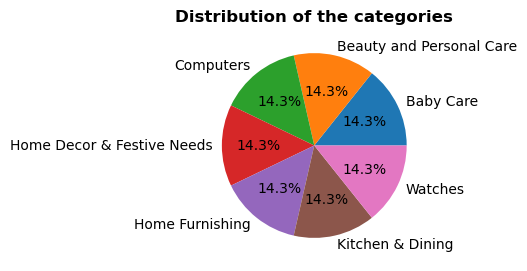

In [9]:
# Plot pie chart
plt.figure(figsize=(5,3))
plt.pie(text_data.groupby(["labels"]).size(),labels=text_data.groupby(["labels"]).size().index,autopct='%1.1f%%')
plt.title(f"Distribution of the categories",fontweight="bold")
plt.show()

**Nettoyage**

In [10]:
# cleaning the text

def text_cleaning(text):
    
    '''
    Lowercase text, remove text in square brackets, links, punctuation, numbers etc..
    '''
    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.lower()
    return text

# Applying the cleaning function to the dataset
text_data["description_cleaned"] = text_data["description"].apply(lambda x: text_cleaning(x))
text_data["description_cleaned"].head()

0    key features of elegance polyester multicolor ...
1    specifications of sathiyas cotton bath towel  ...
2    key features of eurospa cotton terry face towe...
3    key features of santosh royal fashion cotton p...
4    key features of jaipur print cotton floral kin...
Name: description_cleaned, dtype: object

**Tokénisation des descriptions**

La tokénization est un procédé très simple qui divise une chaîne de caractère en tokens, c'est-à-dire des éléments atomiques de la chaîne. Un token n'est pas forcément un mot, ce peut être par exemple une ponctuation. 

In [11]:
# Tokenization 
tokenizer = RegexpTokenizer(r'\w+')
text_data["description_tokenized"] = text_data["description_cleaned"].apply(lambda x:tokenizer.tokenize(x))
text_data["description_tokenized"].head()

0    [key, features, of, elegance, polyester, multi...
1    [specifications, of, sathiyas, cotton, bath, t...
2    [key, features, of, eurospa, cotton, terry, fa...
3    [key, features, of, santosh, royal, fashion, c...
4    [key, features, of, jaipur, print, cotton, flo...
Name: description_tokenized, dtype: object

**Mots d'arrêt(Stop Words)**

Les stopwords dans un texte représentent tous les mots qui n'ont que peu d'intérêt sémantique. Ils sont en effet tous les mots les plus courants d'une langue (déterminants, pronoms, etc..).

In [12]:
# stopwords
nltk_stopwords = stopwords.words("english")

display("Number of nltk stopwords :",len(nltk_stopwords))

# list of nltk stopwords
display("list of nltk stopwords :",nltk_stopwords)

'Number of nltk stopwords :'

179

'list of nltk stopwords :'

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [13]:
# removing stopwords
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words("english")]
    return words 
text_data["description_tokenized"] = text_data["description_tokenized"].apply(lambda x : remove_stopwords(x))
text_data.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description           labels  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   

                                 description_cleaned  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel  ...   
2  key features of eurospa cotton terry face towe...   
3  key features of santosh royal fashion cotton p...   
4  key features of jaipur print cotton floral kin...   

                               description_tokenized  
0  [key, features, elegance, polyester, multicolo...  
1  [specifications, sathiyas, cotton, bath, towel...  
2  [key, features, eurospa, cotton, terry, face, ...  
3  [key, features, santosh, royal, fashion, cotto...  
4  [key, features, jaipur, print, cotton, floral,...

**Lemmatisation des tokens**

La lemmatisation permet de représenter sous un même mot plusieurs dérivées du mot. Elle laisse au mot un sens sémantique mais va éliminer le genre ou le pluriel par exemple.

In [14]:
# nltk.download('wordnet')

In [14]:
# lemmatization
lemmatizer = WordNetLemmatizer()
def lem_word(x):
    return [lemmatizer.lemmatize(w) for w in x]
text_data["description_tokenized"] = text_data["description_tokenized"].apply(lem_word)
text_data["description_tokenized"].head()

0    [key, feature, elegance, polyester, multicolor...
1    [specification, sathiyas, cotton, bath, towel,...
2    [key, feature, eurospa, cotton, terry, face, t...
3    [key, feature, santosh, royal, fashion, cotton...
4    [key, feature, jaipur, print, cotton, floral, ...
Name: description_tokenized, dtype: object

In [15]:
# My new corpus 
def rejoin_words(tokenized_column):    
    return (" ".join(tokenized_column))

text_data["corpus"] = text_data.apply(lambda x: rejoin_words(x["description_tokenized"]), axis=1)
text_data["corpus"].head()

0    key feature elegance polyester multicolor abst...
1    specification sathiyas cotton bath towel bath ...
2    key feature eurospa cotton terry face towel se...
3    key feature santosh royal fashion cotton print...
4    key feature jaipur print cotton floral king si...
Name: corpus, dtype: object

In [16]:
text_data.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description           labels  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   

                                 description_cleaned  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel  ...   
2  key features of eurospa cotton terry face towe...   
3  key features of santosh royal fashion cotton p...   
4  key features of jaipur print cotton floral kin...   

                               description_tokenized  \
0  [key, feature, elegance, polyester, multicolor...   
1  [specification, sathiyas, cotton, bath, towel,...   
2  [key, feature, eurospa, cotton, terry, face, t...   
3  [key, feature, santosh, royal, fashion, cotton...   
4  [key, feature, jaipur, print, cotton, floral, ...   

                                              corpus  
0  key feature elegance polyester multicolor abst...  
1  specification sathiyas cotton bath towel bath ...  
2  key feature eurospa cotton terry face towel se...  
3  key feature santosh royal fashion cotton print...  
4  key feature jaipur print cotton floral king si...

**La distribution des mots dans le corpus**

In [17]:
# Frequency of all words of all products in the description
corpus = ' '.join(text_data["corpus"].tolist())
#print(corpus)
tokens = word_tokenize(corpus)
print(f"Le corpus nettoyé contient {len(tokens)} mots.")              
print(f"Le corpus nettoyé contient {len(set(tokens))} mots uniques.")

Le corpus nettoyé contient 53700 mots.
Le corpus nettoyé contient 4838 mots uniques.


In [18]:
# Instanciate FreqDist 
fdist = FreqDist(tokens)
# Top 20 most frequent words
print(f"Les tokens les plus fréquents et leurs fréquences d'apparition :\n\n{fdist.most_common(20)}")   

Les tokens les plus fréquents et leurs fréquences d'apparition :

[('product', 861), ('free', 612), ('r', 594), ('buy', 581), ('delivery', 567), ('genuine', 564), ('shipping', 564), ('cash', 564), ('price', 559), ('replacement', 559), ('day', 552), ('cm', 539), ('flipkartcom', 472), ('guarantee', 471), ('mug', 449), ('feature', 403), ('online', 396), ('watch', 355), ('color', 354), ('type', 324)]


**Représentation graphique des mots les plus fréquents**

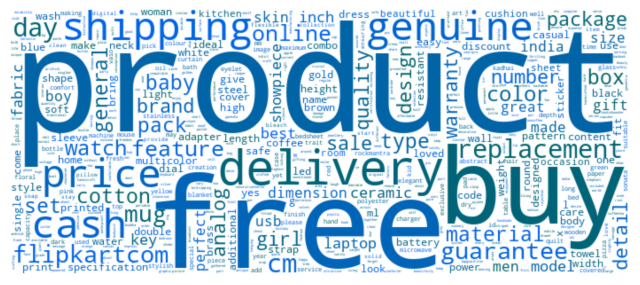

In [19]:
# Wordcloud of the corpora
def couleur(*args, **kwargs):
    return "rgb(0, 100, {})".format(random.randint(100, 250))
    
# Instanciate WordCloud
wordcloud = WordCloud(background_color="White", width = 700, height = 300, random_state=1, collocations=False, 
                     max_font_size=500, max_words=510, colormap="Purples_r").generate(corpus)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud.recolor(color_func = couleur),interpolation="gaussian")
plt.axis("off")
plt.show()

# II. Vectorisation du corpus

## II.1. Approches BOW(bag of words) : CountVectoriser et TF-IDF

- Le terme bag-of-words signifie que l'ordre des mots dans la phrase n'est pas pris en compte, contrairement à des approches plus poussées de Deep Learning (word embeddings : word2vec, GLoVE ou FastText)
- Je commence d'abord par numériser les labels de la colonne "labels" à l'aide de la méthode LabelEncoder de scikit-learn.
- Je concerve uniquement les descriptions et les catégories des produits.

In [20]:
# Encoding the categories
label_encoder = LabelEncoder()
text_to_vectorize = text_data.copy()
text_to_vectorize["labels_encoded"] = label_encoder.fit_transform(np.array(text_to_vectorize["labels"]))
text_to_vectorize = text_to_vectorize[["corpus","labels","labels_encoded"]]
text_to_vectorize.sample(10)

corpus  \
263   buy woodino handicraft showpiece cm online woo...   
634   key feature wow baby girl gathered pink dress ...   
727   buy gift studio ganesha stone showpiece cm onl...   
793   ollington st collection baby reusable diaper o...   
553   sonata analog watch woman buy sonata analog wa...   
567   sonata analog watch woman buy sonata analog wa...   
120   key feature quilt india floral cushion cover w...   
788   perucci decker analog watch men buy perucci de...   
170   prithish eye abstract painting ceramic mug ml ...   
1006  elf cosmetic studio brow kit ash brow makeup b...   

                          labels  labels_encoded  
263   Home Decor & Festive Needs               3  
634                    Baby Care               0  
727   Home Decor & Festive Needs               3  
793                    Baby Care               0  
553                      Watches               6  
567                      Watches               6  
120              Home Furnishing               4  
788                      Watches               6  
170             Kitchen & Dining               5  
1006    Beauty and Personal Care               1

In [21]:
index_mat = label_encoder.inverse_transform([ 0, 1, 2, 3, 4, 5, 6])
index_mat

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [23]:
# pip install --upgrade threadpoolctl

### CountVectorizer

In [27]:
def count_vectorizer(textcolonne):

    count_vectorizer = CountVectorizer(stop_words="english",ngram_range=(1, 2))                  
    count_vectorizer_transform = count_vectorizer.fit_transform(textcolonne)                   
    # Count Vectorizer dataset
    # yield a Sparse matrix to numpy array to pandas DataFrame
    counter_data=pd.DataFrame(count_vectorizer_transform.toarray(),columns=count_vectorizer.get_feature_names_out())
    
    return counter_data

temps1 = time.time()
CountVec = count_vectorizer(text_to_vectorize.corpus)
counter_vectorizer_data = pd.concat([CountVec, text_to_vectorize], axis=1)
duration1=time.time()-temps1
print("temps de la vectorisation CountVectorizer : ", "%15.2f" % duration1, "secondes")
counter_vectorizer_data

temps de la vectorisation CountVectorizer :             0.19 secondes


aa  aa battery  aa pencil  aaa  aaa battery  aapno  aapno rajasthan  \
0      0           0          0    0            0      0                0   
1      0           0          0    0            0      0                0   
2      0           0          0    0            0      0                0   
3      0           0          0    0            0      0                0   
4      0           0          0    0            0      0                0   
...   ..         ...        ...  ...          ...    ...              ...   
1045   0           0          0    0            0      0                0   
1046   0           0          0    0            0      0                0   
1047   0           0          0    0            0      0                0   
1048   0           0          0    0            0      0                0   
1049   0           0          0    0            0      0                0   

      aapno rajasthanspecifications  aari  aari embroidered  ...  zoom type  \
0                                 0     0                 0  ...          0   
1                                 0     0                 0  ...          0   
2                                 0     0                 0  ...          0   
3                                 0     0                 0  ...          0   
4                                 0     0                 0  ...          0   
...                             ...   ...               ...  ...        ...   
1045                              0     0                 0  ...          0   
1046                              0     0                 0  ...          0   
1047                              0     0                 0  ...          0   
1048                              0     0                 0  ...          0   
1049                              0     0                 0  ...          0   

      zora  zora laptop  zyxel  zyxel data  zyxel flipkartcom  zyxel wireless  \
0        0            0      0           0                  0               0   
1        0            0      0           0                  0               0   
2        0            0      0           0                  0               0   
3        0            0      0           0                  0               0   
4        0            0      0           0                  0               0   
...    ...          ...    ...         ...                ...             ...   
1045     0            0      0           0                  0               0   
1046     0            0      0           0                  0               0   
1047     0            0      0           0                  0               0   
1048     0            0      0           0                  0               0   
1049     0            0      0           0                  0               0   

                                                 corpus           labels  \
0     key feature elegance polyester multicolor abst...  Home Furnishing   
1     specification sathiyas cotton bath towel bath ...        Baby Care   
2     key feature eurospa cotton terry face towel se...        Baby Care   
3     key feature santosh royal fashion cotton print...  Home Furnishing   
4     key feature jaipur print cotton floral king si...  Home Furnishing   
...                                                 ...              ...   
1045  oren empower extra large self adhesive sticker...        Baby Care   
1046  wallmantra large vinyl sticker sticker pack pr...        Baby Care   
1047  buy uberlyfe extra large pigmented polyvinyl f...        Baby Care   
1048  buy wallmantra medium vinyl sticker sticker on...        Baby Care   
1049  buy uberlyfe large vinyl sticker online uberly...        Baby Care   

      labels_encoded  
0                  4  
1                  0  
2                  0  
3                  4  
4                  4  
...              ...  
1045               0  
1046               0  
1047               0  
1048            

### TF-IDF (Term Frequency-Inverse Document Frequency)

TFIDF est une approche bag-of-words permettant de représenter les mots d'un document à l'aide d'une matrice de nombres. TFIDF est une méthode efficace puisqu'elle donne de l'importance aux mots qui apparaissent de temps en temps mais pas trop, tout en limitant l'importance des mots qui apparaissent souvent.

In [28]:
def tfidf_vectorizer(textcolonne):

    tfidf_vectorizer = TfidfVectorizer(stop_words="english",ngram_range=(1,2))                  
    tfidf_vectorizer_matrix = tfidf_vectorizer.fit_transform(textcolonne)                   
    
    # TF-IDF dataset ---> Sparse matrix to dense to pandas DataFrame
    feature_names = tfidf_vectorizer.get_feature_names_out() # to get the names of the tokens
    dense_data = tfidf_vectorizer_matrix.todense() # converse sparse matrix to numpy array
    dense_list = dense_data.tolist() # converse numpy array to list
    tf_idf_data = pd.DataFrame(dense_list, columns=feature_names) # converse to pandas DataFrame
    
    return tf_idf_data

temps1 = time.time()
tf_idf = tfidf_vectorizer(text_to_vectorize.corpus)
tf_idf_data = pd.concat([tf_idf, text_to_vectorize], axis=1)
duration1=time.time()-temps1
print("temps de tf-idf : ", "%15.2f" % duration1, "secondes")
tf_idf_data

temps de tf-idf :             2.94 secondes


aa  aa battery  aa pencil  aaa  aaa battery  aapno  aapno rajasthan  \
0     0.0         0.0        0.0  0.0          0.0    0.0              0.0   
1     0.0         0.0        0.0  0.0          0.0    0.0              0.0   
2     0.0         0.0        0.0  0.0          0.0    0.0              0.0   
3     0.0         0.0        0.0  0.0          0.0    0.0              0.0   
4     0.0         0.0        0.0  0.0          0.0    0.0              0.0   
...   ...         ...        ...  ...          ...    ...              ...   
1045  0.0         0.0        0.0  0.0          0.0    0.0              0.0   
1046  0.0         0.0        0.0  0.0          0.0    0.0              0.0   
1047  0.0         0.0        0.0  0.0          0.0    0.0              0.0   
1048  0.0         0.0        0.0  0.0          0.0    0.0              0.0   
1049  0.0         0.0        0.0  0.0          0.0    0.0              0.0   

      aapno rajasthanspecifications  aari  aari embroidered  ...  zoom type  \
0                               0.0   0.0               0.0  ...        0.0   
1                               0.0   0.0               0.0  ...        0.0   
2                               0.0   0.0               0.0  ...        0.0   
3                               0.0   0.0               0.0  ...        0.0   
4                               0.0   0.0               0.0  ...        0.0   
...                             ...   ...               ...  ...        ...   
1045                            0.0   0.0               0.0  ...        0.0   
1046                            0.0   0.0               0.0  ...        0.0   
1047                            0.0   0.0               0.0  ...        0.0   
1048                            0.0   0.0               0.0  ...        0.0   
1049                            0.0   0.0               0.0  ...        0.0   

      zora  zora laptop  zyxel  zyxel data  zyxel flipkartcom  zyxel wireless  \
0      0.0          0.0    0.0         0.0                0.0             0.0   
1      0.0          0.0    0.0         0.0                0.0             0.0   
2      0.0          0.0    0.0         0.0                0.0             0.0   
3      0.0          0.0    0.0         0.0                0.0             0.0   
4      0.0          0.0    0.0         0.0                0.0             0.0   
...    ...          ...    ...         ...                ...             ...   
1045   0.0          0.0    0.0         0.0                0.0             0.0   
1046   0.0          0.0    0.0         0.0                0.0             0.0   
1047   0.0          0.0    0.0         0.0                0.0             0.0   
1048   0.0          0.0    0.0         0.0                0.0             0.0   
1049   0.0          0.0    0.0         0.0                0.0             0.0   

                                                 corpus           labels  \
0     key feature elegance polyester multicolor abst...  Home Furnishing   
1     specification sathiyas cotton bath towel bath ...        Baby Care   
2     key feature eurospa cotton terry face towel se...        Baby Care   
3     key feature santosh royal fashion cotton print...  Home Furnishing   
4     key feature jaipur print cotton floral king si...  Home Furnishing   
...                                                 ...              ...   
1045  oren empower extra large self adhesive sticker...        Baby Care   
1046  wallmantra large vinyl sticker sticker pack pr...        Baby Care   
1047  buy uberlyfe extra large pigmented polyvinyl f...        Baby Care   
1048  buy wallmantra medium vinyl sticker sticker on...        Baby Care   
1049  buy uberlyfe large vinyl sticker online uberly...        Baby Care   

      labels_encoded  
0                  4  
1                  0  
2                  0  
3                  4  
4                  4  
...              ...  
1045               0  
1046               0  
1047               0  
1048 

# II.1.a. Entraînement d'un modèle KMeans avec les deux approches BOW

In [29]:
# KMeans model on tf_idf data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_tf_idf =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_tf_idf.fit(tf_idf)

# KMeans model on countVec data
kmeans_countVec =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_countVec.fit(CountVec)

KMeans(n_clusters=7, n_init=10, random_state=42)

## II.1.b. Score ARI et représentation T-SNE en 2D

In [30]:
# Dimension reduction with T-SNE on tf_idf data
tsne_tf_idf = TSNE(n_components=2,perplexity=50,n_iter=2000,learning_rate=200, init="random",random_state=42)
X_tfidf_tsne = tsne_tf_idf.fit_transform(tf_idf)

# Dimension reduction with T-SNE on countVec data
tsne_countVec = TSNE(n_components=2,perplexity=50,n_iter=2000,learning_rate=200, init="random",random_state=42)
X_countvec_tsne = tsne_countVec.fit_transform(CountVec)

In [30]:
# Visualization with Tsne according to real categories and according to clusters
categories = list(text_to_vectorize.labels.unique())
def Tsne_2D(X,y_true,clusters) :
    # ARI score 
    ari_score = np.round(adjusted_rand_score(y_true, clusters),3)
    print(f"Le score ARI de mesure de similarité est de : {ari_score}")
    fig = plt.figure(figsize=(15,5),tight_layout=True)
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X[:,0],X[:,1],c=y_true,cmap="Set1") 
    ax.legend(handles=scatter.legend_elements()[0],labels=categories,bbox_to_anchor=(1,1),title="True classes")
    plt.title("Projection 2D with real categories",fontweight="bold")
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X[:,0],X[:,1],c=clusters, cmap="Set1")
    ax.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1),labels=set(clusters),title="Clusters")
    plt.title("Projection 2D with estimated clusters",fontweight="bold")
    
    plt.show()

### Cas de l'approche count vectorizer

In [32]:
countVec_conf_mat = confusion_matrix(counter_vectorizer_data["labels_encoded"], kmeans_countVec.labels_)
print(countVec_conf_mat)

[[ 38   0   0  78   0   0  34]
 [101   0   0   0   0   0  49]
 [ 94  10   0   0   0   0  46]
 [ 76   0   0   0   0   0  74]
 [ 74   0   0   0   0   0  76]
 [ 51   0  11   0   0  21  67]
 [  0   0   0   0 139   0  11]]


In [33]:
np.argmax(countVec_conf_mat,axis=0)

array([1, 2, 5, 0, 6, 5, 4], dtype=int64)

In [34]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [1, 2, 3, 0, 6, 5, 4]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_countVec_labels_transform = conf_mat_transform(counter_vectorizer_data["labels_encoded"], kmeans_countVec.labels_)

Correspondance des clusters :  [1, 2, 3, 0, 6, 5, 4]


Le score ARI de mesure de similarité est de : 0.162


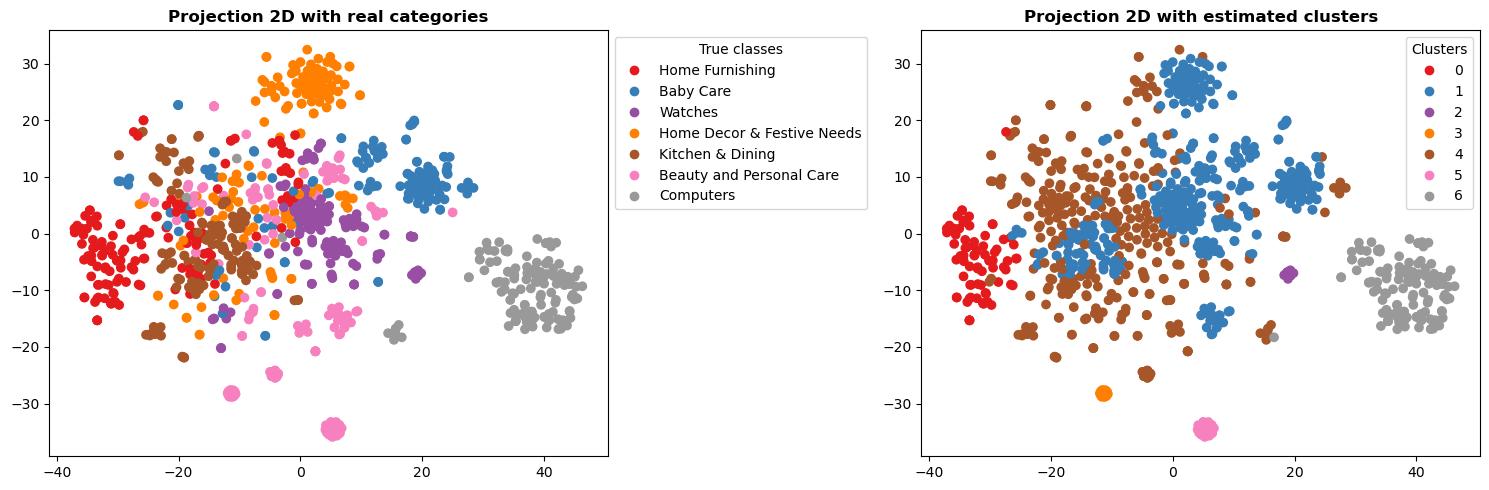

In [35]:
# countVec labels and clusters clusters
y_true_countVec = counter_vectorizer_data["labels_encoded"]
y_pred_countVec = kmeans_countVec.labels_
# Tsne 2D for countVec data
Tsne_2D(X_countvec_tsne,y_true_countVec,kmeans_countVec_labels_transform)

### Cas de l'approche tf-idf

In [36]:
# confusion matrix for tfidf data
conf_mat_tf_idf = confusion_matrix(tf_idf_data["labels_encoded"],kmeans_tf_idf.labels_) 
conf_mat_tf_idf

array([[ 0,  0, 36, 20, 14, 79,  1],
       [ 0,  0, 49, 80, 21,  0,  0],
       [ 0,  0, 57, 68, 25,  0,  0],
       [ 0,  0, 74,  0, 76,  0,  0],
       [ 0,  0, 76, 74,  0,  0,  0],
       [ 0,  0, 47,  3, 48,  0, 52],
       [45, 90, 15,  0,  0,  0,  0]], dtype=int64)

In [37]:
np.argmax(conf_mat_tf_idf, axis=0) 

array([6, 6, 4, 1, 3, 0, 5], dtype=int64)

In [38]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [2,6,4,1,3,0,5]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_tf_idf_labels_transform = conf_mat_transform(tf_idf_data["labels_encoded"], kmeans_tf_idf.labels_)

Correspondance des clusters :  [2, 6, 4, 1, 3, 0, 5]


Le score ARI de mesure de similarité est de : 0.191


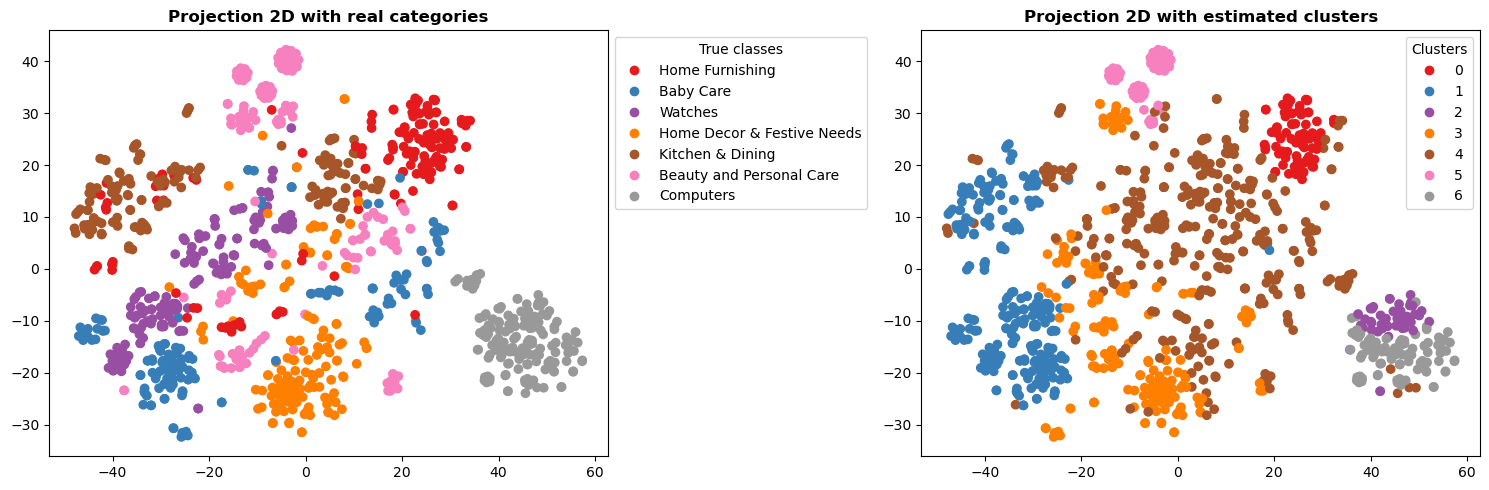

In [39]:
# tf_idf labels and clusters clusters
y_true_tf_idf = tf_idf_data["labels_encoded"]
y_pred_tf_idf = kmeans_tf_idf_labels_transform
# Tsne 2D for tf-idf data
Tsne_2D(X_tfidf_tsne,y_true_tf_idf,y_pred_tf_idf)

- L'inspection visuelle des deux approches bag-of-words que j'ai testées confirment la faisabilité de la classification automatique des classes.
- Les clusters obtenus avec la méthode TF-IDF sont mieux séparés que ceux avec le modèle countvectorizer, ceci étant confirmé par les valeurs de leurs score ARI respectifs. 
- La représentation en 2D des clusters obtenues(mais aussi les score ari obtenus) confirme néanmoins les limites des deux approches bag-of-words qui donnent des clusters pas très optimaux. Nous pouvons par exemple envigager d'améliorer la performance de ces modèles ou de simplement essayer d'autres approches.

## II.1.c. Analyse par classes

### Approche Countvectorizer

In [40]:
conf_mat_countVec = confusion_matrix(y_true_countVec, kmeans_countVec_labels_transform)
print(conf_mat_countVec)
print()
print(classification_report(y_true_countVec, kmeans_countVec_labels_transform))

[[ 78  38   0   0  34   0   0]
 [  0 101   0   0  49   0   0]
 [  0  94  10   0  46   0   0]
 [  0  76   0   0  74   0   0]
 [  0  74   0   0  76   0   0]
 [  0  51   0  11  67  21   0]
 [  0   0   0   0  11   0 139]]

              precision    recall  f1-score   support

           0       1.00      0.52      0.68       150
           1       0.23      0.67      0.35       150
           2       1.00      0.07      0.12       150
           3       0.00      0.00      0.00       150
           4       0.21      0.51      0.30       150
           5       1.00      0.14      0.25       150
           6       1.00      0.93      0.96       150

    accuracy                           0.40      1050
   macro avg       0.64      0.40      0.38      1050
weighted avg       0.64      0.40      0.38      1050



In [34]:
list_labels = text_to_vectorize.labels.unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

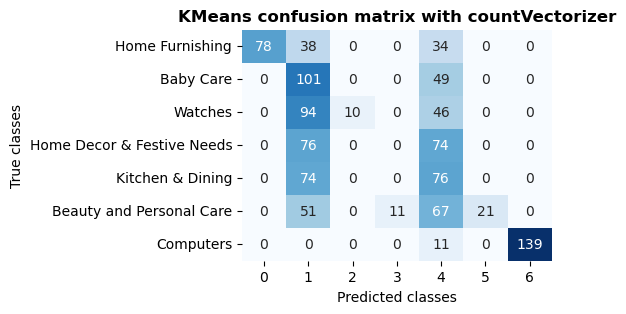

In [42]:
df_cm_countVec = pd.DataFrame(conf_mat_countVec, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_countVec, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with countVectorizer",fontweight="bold")
plt.show()

### Approche TF-IDF

In [43]:
tf_idf_conf_mat = confusion_matrix(tf_idf_data["labels_encoded"], kmeans_tf_idf_labels_transform)
print(tf_idf_conf_mat)
print()
print(classification_report(tf_idf_data["labels_encoded"], kmeans_tf_idf_labels_transform))

[[79 20  0 14 36  1  0]
 [ 0 80  0 21 49  0  0]
 [ 0 68  0 25 57  0  0]
 [ 0  0  0 76 74  0  0]
 [ 0 74  0  0 76  0  0]
 [ 0  3  0 48 47 52  0]
 [ 0  0 45  0 15  0 90]]

              precision    recall  f1-score   support

           0       1.00      0.53      0.69       150
           1       0.33      0.53      0.41       150
           2       0.00      0.00      0.00       150
           3       0.41      0.51      0.46       150
           4       0.21      0.51      0.30       150
           5       0.98      0.35      0.51       150
           6       1.00      0.60      0.75       150

    accuracy                           0.43      1050
   macro avg       0.56      0.43      0.44      1050
weighted avg       0.56      0.43      0.44      1050



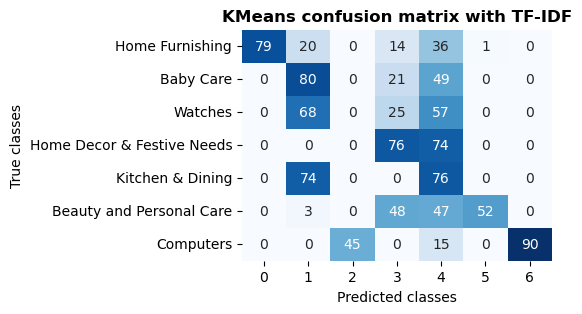

In [44]:
df_cm_tf_idf = pd.DataFrame(tf_idf_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_tf_idf, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with TF-IDF",fontweight="bold")
plt.show()

# II.2. Vectorisation par Word/Sentence Embedding (Incorporation de mots/phrases)

L'incorporation de mots est une technique utilisée en traitement automatique du langage naturel(NLP) pour représenter des mots sous forme de vecteurs denses, ce qui permet aux mots ayant le même sens d'avoir des représentations similaires. L'idée est simple : les mots qui apparaissent dans les mêmes contextes ont tendance à avoir des significations similaires.


## II.2.1. Approche Word2Vec

Word2Vec :
T. Mikolov et al. ont présenté Word2vec en 2013, qui apprend la signification des mots simplement en traitant un grand corpus de texte non étiqueté. L'approche Word2Vec utilise des réseaux neuronaux superficiels avec deux couches cachées, un sac de mots continu (CBOW) et le modèle Skip-gram pour créer un vecteur de grande dimension pour chaque mot. C'est cette nature non supervisée de Word2vec qui le rend assez puissant.

### II.2.2.a. Extraction des features

In [22]:
# Building and training Word2vec model
sentences = text_to_vectorize["corpus"].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
word2vec_model = Word2Vec(sentences=sentences,vector_size=100,epochs=100,window=5)
word2vec_model.build_vocab(sentences)
word2vec_model_vectors = word2vec_model.wv
word2vec_vocabulary = word2vec_model_vectors.index_to_key

In [23]:
# Map text data to Word2Vec embeddings
def text_embedding(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model_vectors:
            vectors.append(word2vec_model_vectors[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)  # Return zeros if no word in vocabulary

temps1 = time.time()
X_word2vec = np.vstack(text_to_vectorize["corpus"].apply(text_embedding))
duration1=time.time()-temps1
print("temps de Word2Vec : ", "%15.2f" % duration1, "secondes")
X_word2vec

temps de Word2Vec :             0.22 secondes


array([[ 1.0832928e-01, -5.1446997e-02,  1.1480502e-01, ...,
         4.0703446e-01,  2.2269705e-01, -3.9291561e-01],
       [ 1.0531808e+00,  3.6131892e-01, -2.3154883e-02, ...,
        -3.0814223e-02, -4.6544215e-01, -1.1863190e-01],
       [ 8.6295134e-01,  4.3472251e-01, -1.9813312e-02, ...,
        -2.9655895e-01,  4.3035369e-02, -3.2392454e-01],
       ...,
       [-5.9244406e-01,  6.7727827e-02, -9.5608120e-04, ...,
        -3.3811921e-01,  1.3139430e-01,  2.2804338e-01],
       [-3.8912307e-02,  3.4899968e-01,  1.5525800e-01, ...,
         2.5528258e-01,  3.7530020e-02,  1.5890175e-01],
       [-1.9817083e-01,  5.6638867e-02,  6.9944598e-02, ...,
         8.6850367e-02,  2.3209293e-01,  1.9000901e-01]], dtype=float32)

In [24]:
X_word2vec = pd.DataFrame(X_word2vec)
X_word2vec_data = pd.concat([X_word2vec, text_to_vectorize], axis=1)
X_word2vec_data

0         1         2         3         4         5         6  \
0     0.108329 -0.051447  0.114805  0.207495  0.231549  0.390165  1.300372   
1     1.053181  0.361319 -0.023155 -0.341659  0.434200 -0.183884  0.216094   
2     0.862951  0.434723 -0.019813 -0.332771  0.089952  0.032196 -0.003378   
3     0.206676 -0.074808 -0.301522 -0.224072 -0.494825 -0.331561  0.595288   
4     0.362652  0.053376 -0.212417 -0.254068 -0.500550 -0.367780  0.483413   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.020756  0.272761  0.017922  0.104010  0.020897 -0.135974  0.186796   
1046  0.175943  0.292132  0.209624 -0.089480 -0.104232  0.093810  0.360279   
1047 -0.592444  0.067728 -0.000956 -0.076065 -0.505480 -0.176225 -0.158783   
1048 -0.038912  0.349000  0.155258  0.421987 -0.341055 -0.121538 -0.064392   
1049 -0.198171  0.056639  0.069945  0.227024 -0.527236 -0.078422 -0.085888   

             7         8         9  ...        93        94        95  \
0     0.042545 -0.431573 -0.895119  ...  0.126309  0.219420  0.197905   
1    -0.433720  0.537303 -0.379190  ...  0.857772 -0.071294 -0.158875   
2    -0.417726  0.249736 -0.242574  ...  1.049192 -0.253452 -0.304217   
3    -0.722077  0.137297 -0.472568  ...  0.897252 -0.352868 -0.063921   
4    -0.676477  0.113588 -0.415846  ...  0.853859 -0.228438  0.152545   
...        ...       ...       ...  ...       ...       ...       ...   
1045  0.366185  0.110387 -0.035403  ... -0.088332  0.188452  0.060210   
1046  0.049646  0.396161 -0.067476  ...  0.257126 -0.372548  0.307610   
1047 -0.180271  0.187153  0.459746  ...  0.396074 -0.348934  0.258743   
1048 -0.113548  0.697363  0.342402  ...  0.439270 -0.209301  0.313930   
1049 -0.284592  0.417107  0.498383  ...  0.485877 -0.525423  0.490425   

            96        97        98        99  \
0     0.471826  0.407034  0.222697 -0.392916   
1    -0.146082 -0.030814 -0.465442 -0.118632   
2    -0.332788 -0.296559  0.043035 -0.323925   
3    -0.167832 -0.110207 -0.268207 -0.029647   
4    -0.150155  0.053697 -0.205623 -0.069131   
...        ...       ...       ...       ...   
1045  0.233056 -0.163243 -0.142203  0.114488   
1046 -0.287731  0.168771 -0.108801 -0.070611   
1047  0.003187 -0.338119  0.131394  0.228043   
1048 -0.136526  0.255283  0.037530  0.158902   
1049  0.004723  0.086850  0.232093  0.190009   

                                                 corpus           labels  \
0     key feature elegance polyester multicolor abst...  Home Furnishing   
1     specification sathiyas cotton bath towel bath ...        Baby Care   
2     key feature eurospa cotton terry face towel se...        Baby Care   
3     key feature santosh royal fashion cotton print...  Home Furnishing   
4     key feature jaipur print cotton floral king si...  Home Furnishing   
...                                                 ...              ...   
1045  oren empower extra large self adhesive sticker...        Baby Care   
1046  wallmantra large vinyl sticker sticker pack pr...        Baby Care   
1047  buy uberlyfe extra large pigmented polyvinyl f...        Baby Care   
1048  buy wallmantra medium vinyl sticker sticker on...        Baby Care   
1049  buy uberlyfe large vinyl sticker online uberly...        Baby Care   

      labels_encoded  
0                  4  
1                  0  
2                  0  
3                  4  
4                  4  
...              ...  
1045               0  
1046               0  
1047               0  
1048               0  
1049               0  

[1050 rows x 103 columns]

### II.2.1.b. Entraînement d'un modèle KMeans

In [25]:
# KMeans model on word2vec data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_word2vec =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_word2vec.fit(X_word2vec)

KMeans(n_clusters=7, n_init=10, random_state=42)

### II.2.1.c. Score ARI et représentation T-SNE en 2D  

In [26]:
# confusion matrix for word2vec data
conf_mat_word2vec = confusion_matrix(X_word2vec_data["labels_encoded"],kmeans_word2vec.labels_) 
conf_mat_word2vec

array([[ 10,  31,   2,  82,  14,   0,  11],
       [  0,  35,  78,  14,  21,   0,   2],
       [  0,  39,  67,  17,  26,   0,   1],
       [  0,  42,   0,  32,  76,   0,   0],
       [ 17,  16,   0,  51,   0,   0,  66],
       [  0,  83,   2,  15,  49,   0,   1],
       [  0,  10,   0,   5,   0, 135,   0]], dtype=int64)

In [27]:
np.argmax(conf_mat_word2vec, axis=0)

array([4, 5, 1, 0, 3, 6, 4], dtype=int64)

In [28]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [5,1,3,2,0,6,4]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_word2vec_labels_transform = conf_mat_transform(X_word2vec_data["labels_encoded"], kmeans_word2vec.labels_)

Correspondance des clusters :  [5, 1, 3, 2, 0, 6, 4]


Le score ARI de mesure de similarité est de : 0.261


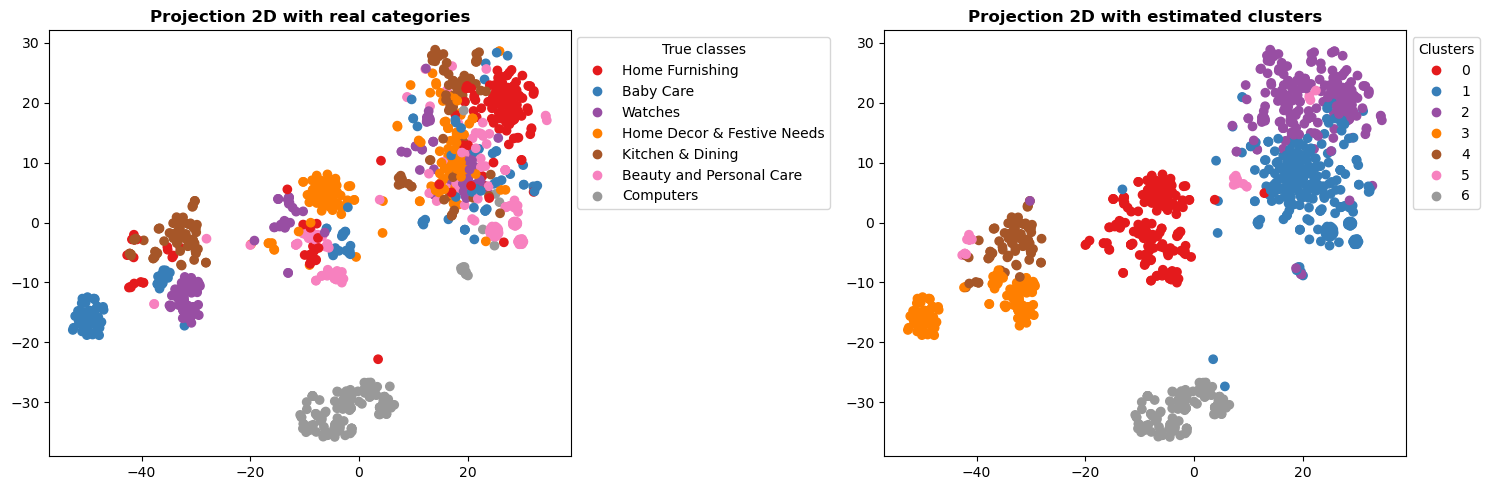

In [31]:
# Dimension reduction with T-SNE on word2vec data
tsne_word2vec = TSNE(n_components=2,perplexity=50,n_iter=2000,learning_rate=200, init="random",random_state=42)
X_word2vec_tsne = tsne_word2vec.fit_transform(X_word2vec)

# word2vec labels and clusters clusters
y_true_word2vec = X_word2vec_data["labels_encoded"]
y_pred_word2vec = kmeans_word2vec_labels_transform
# Tsne 2D for word2vec data
Tsne_2D(X_word2vec_tsne,y_true_word2vec,y_pred_word2vec)

- L'approche Word2vec donne des clusters mieux séparés par rapport aux approches bag-of-words et on obtient un temps d'éxecution assez rapide de la vectorisation(0.22 secondes).
- Le score ARI obtenu est également plus grand.

### II.2.1.d. Analyse par classes

In [32]:
word2vec_conf_mat = confusion_matrix(X_word2vec_data["labels_encoded"], kmeans_word2vec_labels_transform)
print(word2vec_conf_mat)
print()
print(classification_report(X_word2vec_data["labels_encoded"], kmeans_word2vec_labels_transform))

[[ 14  31  82   2  11  10   0]
 [ 21  35  14  78   2   0   0]
 [ 26  39  17  67   1   0   0]
 [ 76  42  32   0   0   0   0]
 [  0  16  51   0  66  17   0]
 [ 49  83  15   2   1   0   0]
 [  0  10   5   0   0   0 135]]

              precision    recall  f1-score   support

           0       0.08      0.09      0.08       150
           1       0.14      0.23      0.17       150
           2       0.08      0.11      0.09       150
           3       0.00      0.00      0.00       150
           4       0.81      0.44      0.57       150
           5       0.00      0.00      0.00       150
           6       1.00      0.90      0.95       150

    accuracy                           0.25      1050
   macro avg       0.30      0.25      0.27      1050
weighted avg       0.30      0.25      0.27      1050



In [36]:
list_labels = text_to_vectorize.labels.unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

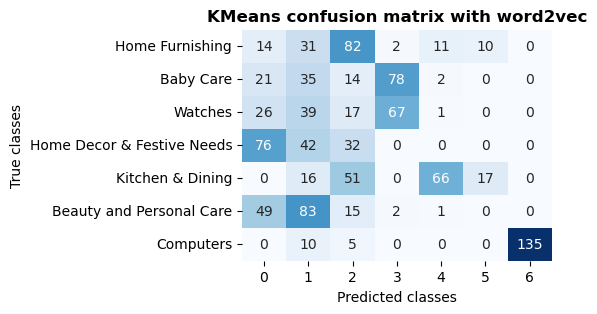

In [37]:
df_cm_word2vec = pd.DataFrame(word2vec_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_word2vec, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with word2vec",fontweight="bold")
plt.show()

## II.2.2. Approche BERT

Représentations d'encodeurs bidirectionnels à partir de transformateurs (BERT) :
BERT est un modèle d'apprentissage profond qui a donné des résultats de pointe sur une grande variété de tâches de traitement du langage naturel. Il signifie Bidirectionnel Encoder Representations for Transformers. Il a été pré-entraîné sur Wikipédia et BooksCorpus et nécessite un réglage fin spécifique à la tâche.

BERT étape par étape:
- Bidirectionnel : BERT prend le passage de texte entier en entrée et lit le passage dans les deux sens pour comprendre le sens de chaque mot.
- Transformers : BERT est basé sur un réseau de Transformers profonds. Le réseau de Transformers est un type de réseau qui peut traiter efficacement de longs textes en utilisant l'attention. Une attention est un mécanisme permettant d'apprendre les relations contextuelles entre les mots d'un texte.
- Encoder Representations : à l'origine, Transformer comprend deux mécanismes distincts : un encodeur qui lit l'entrée de texte et un décodeur qui produit une prédiction pour la tâche. Puisque l'objectif de BERT est de générer un modèle de langage, seul le mécanisme d'encodeur est nécessaire, d'où la le terme << Encoder Representation >>.

### II.2.2.a. Extraction des features

In [4]:
# pip install transformers

In [5]:
# pip install --upgrade transformers

In [6]:
# pip install torch

In [38]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Tokenize and encode text
def encode_text(text):
    inputs = tokenizer(text,return_tensors="pt",padding=True,truncation=True,add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs,output_attentions=True)
    # Extract embeddings from BERT's output
    word_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over tokens
    return word_embeddings

- J'ai chargé un modèle BERT pré-entraîné conçu pour les plongements de mots. J'ai tokénisé le texte d'entrée, l'ai transmis au modèle et j'obtiens les plongements de mots à l'aide de la librairie Transformers de Hugging Face. Le modèle génère des embeddings contextuelles pour chaque mot du texte d'entrée. J'obtiens également l'attention que BERT accorde aux différents mots de la phrase grâce au paramètre output_attentions.

In [39]:
temps1 = time.time()

# Apply encoding to the corpus column to get BERT embedings
X_bert = np.vstack(text_to_vectorize["corpus"].apply(encode_text))

duration1=time.time()-temps1
print("temps de BERT : ", "%15.2f" % duration1, "secondes")
X_bert

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


temps de BERT :           111.03 secondes


array([[-0.07121696,  0.01452761,  0.78822166, ...,  0.05225261,
        -0.0744039 , -0.05089313],
       [ 0.18754871, -0.0445367 ,  0.50805116, ..., -0.13065661,
        -0.12078694,  0.16167298],
       [ 0.07268911,  0.00203785,  0.58957255, ..., -0.18347806,
        -0.23655663,  0.05071454],
       ...,
       [ 0.22338223, -0.05358674,  0.4558082 , ...,  0.05280415,
        -0.03296795, -0.13138947],
       [ 0.19937374, -0.05437276,  0.42869237, ...,  0.26783505,
        -0.10092093, -0.42391562],
       [ 0.370412  , -0.20192121,  0.61170715, ...,  0.1990919 ,
        -0.02239966, -0.18754476]], dtype=float32)

In [40]:
X_bert = pd.DataFrame(X_bert)
X_bert_data = pd.concat([X_bert, text_to_vectorize], axis=1)
X_bert_data

0         1         2         3         4         5         6  \
0    -0.071217  0.014528  0.788222 -0.095934  0.349414  0.038125  0.114470   
1     0.187549 -0.044537  0.508051  0.061791  0.228007  0.001809  0.173739   
2     0.072689  0.002038  0.589573 -0.053331  0.289288 -0.006346 -0.151710   
3     0.114416 -0.043887  0.789521 -0.010880  0.257242 -0.198328 -0.018429   
4     0.152932  0.041758  0.676307 -0.080821  0.232412 -0.120629 -0.073582   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.172886  0.090343  0.417712 -0.191885  0.513945 -0.273728  0.028044   
1046 -0.408007  0.082386  0.576725 -0.063069  0.407291 -0.338766  0.069629   
1047  0.223382 -0.053587  0.455808  0.147175  0.394319 -0.224946 -0.167176   
1048  0.199374 -0.054373  0.428692  0.090906  0.344739 -0.240115  0.072272   
1049  0.370412 -0.201921  0.611707  0.122419  0.427504 -0.143879  0.000035   

             7         8         9  ...       761       762       763  \
0     0.038890 -0.094383 -0.318038  ...  0.130209  0.054015  0.083333   
1    -0.064462 -0.008010 -0.178264  ... -0.065343  0.161342  0.174500   
2     0.154893 -0.043866 -0.185085  ...  0.111940  0.166227  0.205255   
3     0.165563 -0.031426  0.079555  ... -0.117105  0.142889  0.041786   
4     0.229989  0.043077 -0.122283  ... -0.022456  0.016971  0.171254   
...        ...       ...       ...  ...       ...       ...       ...   
1045  0.229858  0.051980 -0.085081  ...  0.224807  0.158756 -0.071277   
1046  0.213620  0.308038 -0.190399  ...  0.155214  0.012642 -0.145695   
1047  0.553789 -0.076326  0.031882  ...  0.022785  0.080528  0.015468   
1048  0.322541  0.126121 -0.214624  ... -0.106969  0.052080 -0.064746   
1049  0.525687 -0.027461 -0.285203  ... -0.157932  0.051942 -0.164254   

           764       765       766       767  \
0    -0.387045  0.052253 -0.074404 -0.050893   
1    -0.397890 -0.130657 -0.120787  0.161673   
2    -0.396673 -0.183478 -0.236557  0.050715   
3    -0.427296 -0.007519  0.049824 -0.045136   
4    -0.569322  0.106811  0.024959 -0.101911   
...        ...       ...       ...       ...   
1045 -0.631997  0.051438 -0.044015  0.113051   
1046 -0.496450  0.013863 -0.056844 -0.192802   
1047 -0.448760  0.052804 -0.032968 -0.131389   
1048 -0.510436  0.267835 -0.100921 -0.423916   
1049 -0.505949  0.199092 -0.022400 -0.187545   

                                                 corpus           labels  \
0     key feature elegance polyester multicolor abst...  Home Furnishing   
1     specification sathiyas cotton bath towel bath ...        Baby Care   
2     key feature eurospa cotton terry face towel se...        Baby Care   
3     key feature santosh royal fashion cotton print...  Home Furnishing   
4     key feature jaipur print cotton floral king si...  Home Furnishing   
...                                                 ...              ...   
1045  oren empower extra large self adhesive sticker...        Baby Care   
1046  wallmantra large vinyl sticker sticker pack pr...        Baby Care   
1047  buy uberlyfe extra large pigmented polyvinyl f...        Baby Care   
1048  buy wallmantra medium vinyl sticker sticker on...        Baby Care   
1049  buy uberlyfe large vinyl sticker online uberly...        Baby Care   

      labels_encoded  
0                  4  
1                  0  
2                  0  
3                  4  
4                  4  
...              ...  
1045               0  
1046               0  
1047               0  
1048               0  
1049               0  

[1050 rows x 771 columns]

### II.2.2.b. Entraînement d'un modèle KMeans

In [41]:
# KMeans model on bert data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_bert =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_bert.fit(X_bert)

KMeans(n_clusters=7, n_init=10, random_state=42)

### II.2.2.c. Score ARI et représentation T-SNE en 2D  

In [42]:
# confusion matrix for bert data
conf_mat_bert = confusion_matrix(X_bert_data["labels_encoded"],kmeans_bert.labels_) 
conf_mat_bert

array([[ 14,  19,   6,   9,  87,   0,  15],
       [ 21,  31,  80,  14,   4,   0,   0],
       [ 22,  37,  69,  22,   0,   0,   0],
       [ 74,  42,   1,  31,   0,   1,   1],
       [  0,  51,   0,  19,   6,   0,  74],
       [ 44,  36,   6,  62,   0,   0,   2],
       [  0,   5,   0,   5,   5, 135,   0]], dtype=int64)

In [43]:
np.argmax(conf_mat_bert, axis=0)

array([3, 4, 1, 5, 0, 6, 4], dtype=int64)

In [44]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 2, 1, 5, 0, 6, 4]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_bert_labels_transform = conf_mat_transform(X_bert_data["labels_encoded"], kmeans_bert.labels_)

Correspondance des clusters :  [3, 2, 1, 5, 0, 6, 4]


Le score ARI de mesure de similarité est de : 0.294


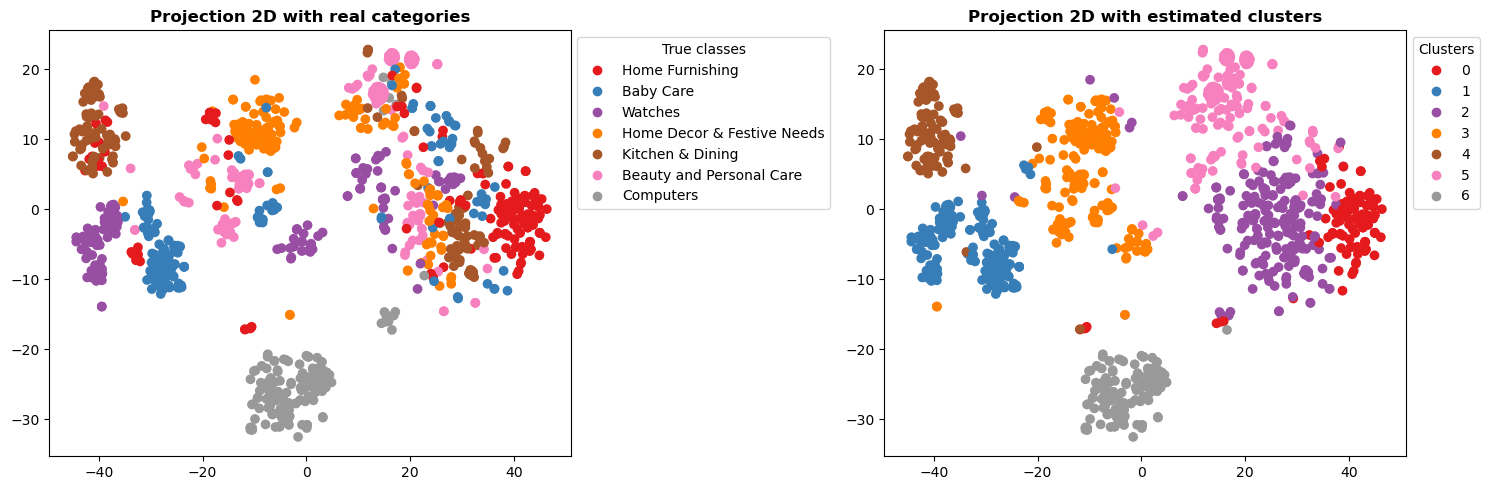

In [45]:
# Dimension reduction with T-SNE on bert data
tsne_bert = TSNE(n_components=2,perplexity=50,n_iter=2000,learning_rate=200, init="random",random_state=42)
X_bert_tsne = tsne_bert.fit_transform(X_bert)

# BERT labels and clusters clusters
y_true_bert = X_bert_data["labels_encoded"]
y_pred_bert = kmeans_bert_labels_transform

# Tsne 2D for BERT data
Tsne_2D(X_bert_tsne,y_true_bert,y_pred_bert)

- On obtient donc une nette amélioration de la catégorisatopn avec BERT.
- Son score ARI est également meilleur que celui de l'approche word2vec, bien que le temps d'éxecution soit beaucoup plus grand (111.03 secondes). 

### II.2.2.d. Analyse par classes

In [46]:
bert_conf_mat = confusion_matrix(X_bert_data["labels_encoded"], kmeans_bert_labels_transform)
print(bert_conf_mat)
print()
print(classification_report(X_bert_data["labels_encoded"], kmeans_bert_labels_transform))

[[ 87   6  19  14  15   9   0]
 [  4  80  31  21   0  14   0]
 [  0  69  37  22   0  22   0]
 [  0   1  42  74   1  31   1]
 [  6   0  51   0  74  19   0]
 [  0   6  36  44   2  62   0]
 [  5   0   5   0   0   5 135]]

              precision    recall  f1-score   support

           0       0.85      0.58      0.69       150
           1       0.49      0.53      0.51       150
           2       0.17      0.25      0.20       150
           3       0.42      0.49      0.46       150
           4       0.80      0.49      0.61       150
           5       0.38      0.41      0.40       150
           6       0.99      0.90      0.94       150

    accuracy                           0.52      1050
   macro avg       0.59      0.52      0.54      1050
weighted avg       0.59      0.52      0.54      1050



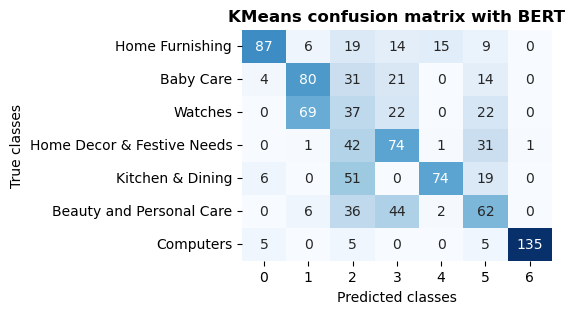

In [47]:
df_cm_bert = pd.DataFrame(bert_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_bert, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with BERT",fontweight="bold")
plt.show()

## II.2.3. Approche Universal Sentence Encoder (USE)

L'encodeur de phrase universel encode le texte en vecteurs de grande dimension qui peuvent être utilisés pour la classification de texte, la similitude sémantique, le regroupement et d'autres tâches en langage naturel. Le modèle pré-formé est disponible publiquement dans Tensorflow-hub. Il est livré avec deux variantes, à savoir l'une formée avec l' encodeur Transformer et l'autre formée avec le Deep Averaging Network (DAN).

Au lieu de calculer la moyenne des incorporations de mots de chaque mot dans une phrase pour obtenir des incorporations de phrase, USE génère des incorporations pour la phrase sans autre calcul.

In [48]:
# pip install tensorflow_hub

In [49]:
# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x179580a8bd0>

### II.2.3.a. Extraction des features

In [50]:
def feature_USE_function(sentences, b_size) :
    batch_size = b_size
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feature = embed(sentences[idx:idx+batch_size])
        if step==0 :
            features = feature
        else :
            features = np.concatenate((features,feature))
    return features

In [51]:
temps1 = time.time()
# Create embeddings to our dataset sentences
batch_size = 10
sentences = text_to_vectorize["corpus"].to_list()
# Applying the USE vectorization function to the dataset
X_USE = feature_USE_function(sentences, batch_size)
X_USE = pd.DataFrame(X_USE)
X_USE_data = pd.concat([X_USE, text_to_vectorize], axis=1)
duration1=time.time()-temps1
print("temps de USE : ", "%15.2f" % duration1, "secondes")
X_USE_data

temps de USE :             0.65 secondes


0         1         2         3         4         5         6  \
0    -0.054183 -0.054041  0.034379  0.052719  0.014841  0.049487 -0.039651   
1    -0.043751 -0.048623 -0.002782  0.045491  0.052363  0.059343  0.049712   
2    -0.053922 -0.049434 -0.026344  0.053708  0.051705  0.053863  0.050278   
3    -0.055404 -0.054638  0.054145  0.053026  0.055311  0.042144  0.027803   
4    -0.052292 -0.051322  0.050579  0.048617  0.052259  0.050457 -0.023752   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.004387 -0.043190  0.048067  0.048747 -0.029635  0.048807 -0.048696   
1046 -0.058374 -0.053391  0.046042  0.057423  0.053689  0.006919 -0.011298   
1047 -0.009058 -0.051976 -0.024585  0.022382 -0.006731  0.060706 -0.071598   
1048 -0.014800 -0.051437  0.040806  0.043113  0.045114  0.050171 -0.067256   
1049 -0.041495 -0.046286  0.034106  0.027717  0.046404  0.058166 -0.067346   

             7         8         9  ...       505       506       507  \
0     0.051077 -0.026669 -0.017512  ...  0.053860 -0.033723 -0.050077   
1    -0.031451 -0.007660 -0.049108  ... -0.050490 -0.018502 -0.048793   
2     0.037310 -0.042342  0.037778  ...  0.015158  0.047399 -0.052581   
3     0.019325  0.035737 -0.052628  ...  0.053260 -0.051037 -0.046109   
4     0.043573  0.020190 -0.049927  ...  0.042759 -0.052097 -0.050689   
...        ...       ...       ...  ...       ...       ...       ...   
1045 -0.016749 -0.048796  0.048804  ... -0.018721  0.048806  0.048807   
1046  0.057795 -0.034182  0.019310  ...  0.039251 -0.057799  0.054296   
1047 -0.004728  0.006157 -0.068793  ...  0.036678 -0.064362 -0.047596   
1048  0.005294  0.030525 -0.067881  ...  0.040181 -0.064592 -0.046799   
1049 -0.016447  0.040175 -0.073346  ...  0.028615 -0.063909 -0.051556   

           508       509       510       511  \
0     0.039175  0.042710  0.033971 -0.042906   
1     0.005099  0.030931  0.034220  0.016958   
2     0.047665  0.050146 -0.023063 -0.047825   
3     0.053766  0.051351 -0.015742 -0.050758   
4     0.052238  0.052126 -0.016224 -0.042181   
...        ...       ...       ...       ...   
1045  0.048051 -0.019393  0.046631 -0.047246   
1046  0.037394  0.056527 -0.041754 -0.052564   
1047  0.068671 -0.031533  0.043754 -0.054699   
1048  0.029401  0.013378 -0.021723  0.000081   
1049  0.064576  0.019291 -0.024416  0.007658   

                                                 corpus           labels  \
0     key feature elegance polyester multicolor abst...  Home Furnishing   
1     specification sathiyas cotton bath towel bath ...        Baby Care   
2     key feature eurospa cotton terry face towel se...        Baby Care   
3     key feature santosh royal fashion cotton print...  Home Furnishing   
4     key feature jaipur print cotton floral king si...  Home Furnishing   
...                                                 ...              ...   
1045  oren empower extra large self adhesive sticker...        Baby Care   
1046  wallmantra large vinyl sticker sticker pack pr...        Baby Care   
1047  buy uberlyfe extra large pigmented polyvinyl f...        Baby Care   
1048  buy wallmantra medium vinyl sticker sticker on...        Baby Care   
1049  buy uberlyfe large vinyl sticker online uberly...        Baby Care   

      labels_encoded  
0                  4  
1                  0  
2                  0  
3                  4  
4                  4  
...              ...  
1045               0  
1046               0  
1047               0  
1048               0  
1049               0  

[1050 rows x 515 columns]

### II.2.3.b. Entraînement d'un modèle KMeans

In [52]:
# KMeans model on USE data
n_clusters = text_to_vectorize.labels.nunique()
kmeans_USE =  KMeans(n_clusters=n_clusters,init ="k-means++",max_iter=300,n_init=10,random_state=42)
kmeans_USE.fit(X_USE)

KMeans(n_clusters=7, n_init=10, random_state=42)

### II.2.3.c. Score ARI et représentation T-SNE en 2D 

In [53]:
# confusion matrix for USE data
conf_mat_USE = confusion_matrix(X_USE_data["labels_encoded"],kmeans_USE.labels_) 
conf_mat_USE

array([[ 16,   1,  84,  15,  18,   1,  15],
       [  0,   0,   0,   6,  99,   0,  45],
       [  0,   0,   0,   3,  91,   0,  56],
       [  0,   0,   0,  23,  76,   0,  51],
       [ 74,   0,   3,  48,   0,   0,  25],
       [  1,  57,   0,  12,  47,   0,  33],
       [  0,   0,   0,  10,   6, 130,   4]], dtype=int64)

In [54]:
np.argmax(conf_mat_USE, axis=0)

array([4, 5, 0, 4, 1, 6, 2], dtype=int64)

In [55]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [4, 5, 0, 3, 1, 6, 2]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels["y_pred"] = y_pred
    labels["y_pred_transform"] = labels["y_pred"].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_USE_labels_transform = conf_mat_transform(X_USE_data["labels_encoded"], kmeans_USE.labels_)

Correspondance des clusters :  [4, 5, 0, 3, 1, 6, 2]


Le score ARI de mesure de similarité est de : 0.263


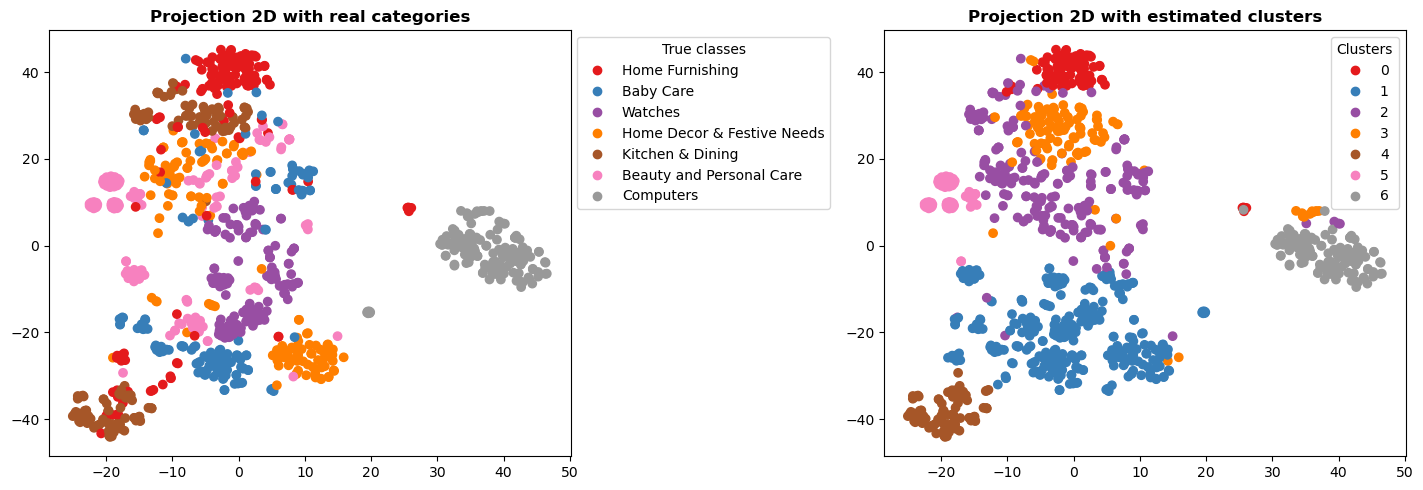

In [56]:
# Dimension reduction with T-SNE on USE data
tsne_USE = TSNE(n_components=2,perplexity=50,n_iter=2000,learning_rate=200, init="random",random_state=42)
X_USE_tsne = tsne_USE.fit_transform(X_USE)

# USE labels and clusters clusters
y_true_USE = X_USE_data["labels_encoded"]
y_pred_USE = kmeans_USE_labels_transform

# Tsne 2D for USE data
Tsne_2D(X_USE_tsne,y_true_USE,y_pred_USE)

- Les résultats obtenus avec USE sont assez bons avec un temps d'éxecution très rapide et des clusters assez bien séparés.
- L'approche BERT reste cependant meilleur pour notre cas d'étude bien qu'étant plus long à éxecuter.

### II.2.3.d. Analyse par classes

In [57]:
USE_conf_mat = confusion_matrix(X_USE_data["labels_encoded"], kmeans_USE_labels_transform)
print(USE_conf_mat)
print()
print(classification_report(X_USE_data["labels_encoded"], kmeans_USE_labels_transform))

[[ 84  18  15  15  16   1   1]
 [  0  99  45   6   0   0   0]
 [  0  91  56   3   0   0   0]
 [  0  76  51  23   0   0   0]
 [  3   0  25  48  74   0   0]
 [  0  47  33  12   1  57   0]
 [  0   6   4  10   0   0 130]]

              precision    recall  f1-score   support

           0       0.97      0.56      0.71       150
           1       0.29      0.66      0.41       150
           2       0.24      0.37      0.30       150
           3       0.20      0.15      0.17       150
           4       0.81      0.49      0.61       150
           5       0.98      0.38      0.55       150
           6       0.99      0.87      0.93       150

    accuracy                           0.50      1050
   macro avg       0.64      0.50      0.52      1050
weighted avg       0.64      0.50      0.52      1050



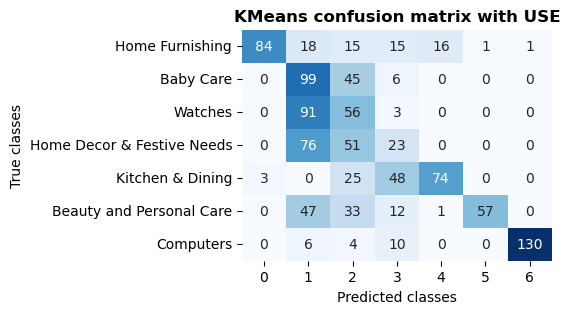

In [58]:
df_cm_USE = pd.DataFrame(USE_conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_USE, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with USE",fontweight="bold")
plt.show()

# III. Prétraitement des données images

In [2]:
# Directory to get to the images
path = "../P6_classification_auto_bien_consommation/Images/"

# List of all the images 
list_photos = [file for file in listdir(path)]
print(f"Le jeu de données contient {len(list_photos)} images.")

Le jeu de données contient 1050 images.


In [3]:
# Import  data
image_data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv') 

# Splitting sub-categories into new columns
classes = image_data["product_category_tree"].str.split(" >> ", expand=True)

# Separate the levels of categories
image_data["labels"] = classes[0] 

# Cleaning the [" in our labels
image_data = image_data.replace('\\["', '', regex=True)

# Encoding the categories
label_encoder = LabelEncoder()
image_data["labels_encoded"] = label_encoder.fit_transform(np.array(image_data["labels"]))

# Keeping images and categories only
image_data = image_data[["image","labels","labels_encoded"]]

# getting the images and all the path 
image_data["image_directory"] = image_data.image.apply(lambda x: path+str(x))
image_data.sample(10)

image                      labels  \
26   4aa047f14885c74f155ce5f973e14dff.jpg                     Watches   
595  dde89969aecfa2c5245e8059c660b139.jpg  Home Decor & Festive Needs   
796  170fdf050c7a1f8d30ef5a98c4216f9c.jpg                     Watches   
185  6da53319cc12c9729881f5478ff67223.jpg            Kitchen & Dining   
994  fc8ff72b68b0f3736a9aff8f03aa712f.jpg            Kitchen & Dining   
740  fd53c8ed19e77c3e65d767e6aee5fad7.jpg                   Computers   
250  17611e6e94d73ef376834e5c6ee03dde.jpg  Home Decor & Festive Needs   
176  154920adb9d584b55d419227f9b01cc6.jpg            Kitchen & Dining   
264  a4951eb41979fe482879f777c8f21d2b.jpg  Home Decor & Festive Needs   
359  4b0e6f200426b1db8824b2ca0c59ecfa.jpg    Beauty and Personal Care   

     labels_encoded                                    image_directory  
26                6  ../P6_classification_auto_bien_consommation/Im...  
595               3  ../P6_classification_auto_bien_consommation/Im...  
796               6  ../P6_classification_auto_bien_consommation/Im...  
185               5  ../P6_classification_auto_bien_consommation/Im...  
994               5  ../P6_classification_auto_bien_consommation/Im...  
740               2  ../P6_classification_auto_bien_consommation/Im...  
250               3  ../P6_classification_auto_bien_consommation/Im...  
176               5  ../P6_classification_auto_bien_consommation/Im...  
264               3  ../P6_classification_auto_bien_consommation/Im...  
359               1  ../P6_classification_auto_bien_consommation/Im...

In [4]:
image_data.groupby("labels_encoded").count()

image  labels  image_directory
labels_encoded                                
0                 150     150              150
1                 150     150              150
2                 150     150              150
3                 150     150              150
4                 150     150              150
5                 150     150              150
6                 150     150              150

## Affichage d'exemples d'images du jeu de données par catégorie.

In [5]:
list_labels = image_data.labels.unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

Exemple d'images de la catégorie Home Furnishing :


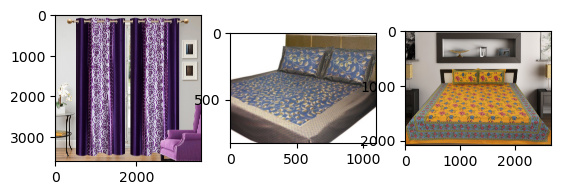

   Exemple d'images de la catégorie Baby Care :   


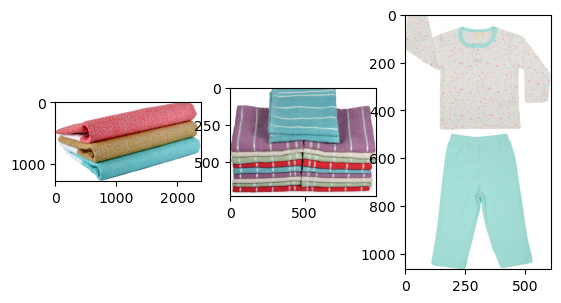

    Exemple d'images de la catégorie Watches :    


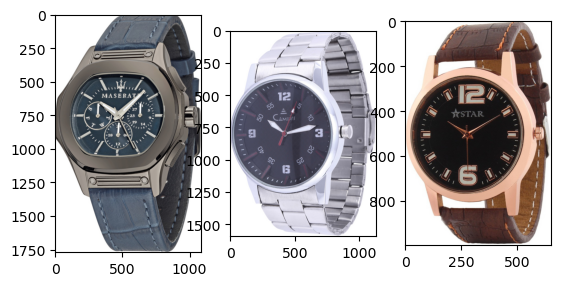

Exemple d'images de la catégorie Home Decor & Festive Needs :


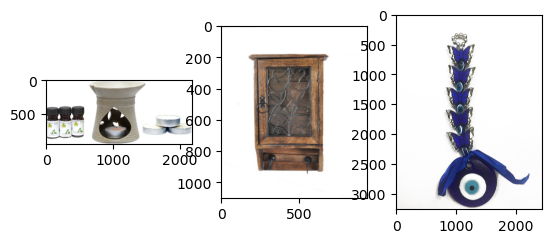

Exemple d'images de la catégorie Kitchen & Dining :


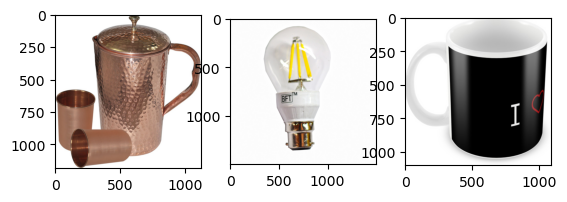

Exemple d'images de la catégorie Beauty and Personal Care :


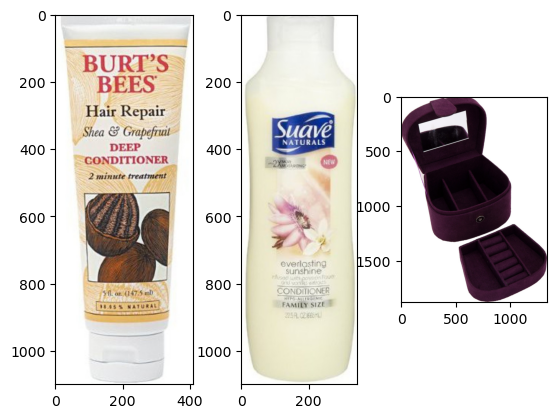

   Exemple d'images de la catégorie Computers :   


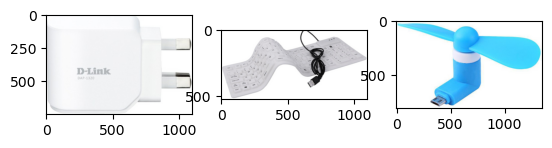

In [6]:
# Some exemples of images in the dataset
for name in list_labels :
    print('\033[1m' + f"Exemple d'images de la catégorie {name} :".center(50)) 
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = image_data.loc[image_data.labels==name]["image_directory"].iloc[i]
        image = imread(filename) 
        plt.imshow(image)
        
    plt.show()

# III.1. Algorithme SIFT

* SIFT (Scale Invariant Feature Transform), cette méthode, développée en 1999 et très populaire dans le domaine de la vision par ordinateur, permet d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs descripteurs.
* L'algorithme SIFT se divise en plusieurs étapes :
    * Détection : création de l'espace des échelles, calcul des "DoG" (Différence of Gaussian), localisation des points d'intérêt.
    * Description : assignation d'orientation, création des descripteurs.

## Exemple sur une image du jeu de données

**Détermination et d'affichage des descripteurs SIFT**

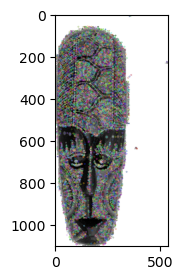

Descripteurs : (8704, 128)
[[  5.   0.   2. ...  38.   1.   0.]
 [  0.   0.   0. ...   5.   4.  25.]
 [139.  68.   2. ...   1.   0.   0.]
 ...
 [  7.  15.  35. ...   0.   0.  16.]
 [  0.   0.   0. ...   0.   1.   1.]
 [ 19.   6.  13. ...   0.   9.  24.]]


In [7]:
# Instanciate SIFT
sift = cv2.SIFT_create()
plt.figure(figsize=(3,3))
# convert in gray
image = cv2.imread(image_data.image_directory.sample(1).iloc[0],0) 
# equalize image histogram
image = cv2.equalizeHist(image)   
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print(f"Descripteurs : {des.shape}")
print(des) 

In [8]:
print(f"L'image que j'ai représenté ici contient {des.shape[0]} descripteurs.")
print(f"Chaque descripteur est un vecteur de longueur {des.shape[1]}.")

L'image que j'ai représenté ici contient 8704 descripteurs.
Chaque descripteur est un vecteur de longueur 128.


# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image du jeu de données

* Pour chaque image, passage en gris et equalisation.
* Création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image.
* Création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs.

In [9]:
# pip install opencv-python==3.4.2.16 opencv-contrib-python==3.4.2.16

In [6]:
temps1 = time.time()
# Identification of key points and associated descriptors
sift_keypoints = []
# Instanciate SIFT feature extractor 
sift = cv2.SIFT_create()

for image_num in range(image_data.shape[0]) :
    # Convert the image in gray
    image = cv2.imread(image_data.image_directory.iloc[image_num],0) 
    # equalize image histogram
    res = cv2.equalizeHist(image)   
    # detect the key points and descriptors
    keypoints, descriptors = sift.detectAndCompute(res, None) 
    # Add to the descriptor list for the image
    sift_keypoints.append(descriptors)

# list of descriptors per image: used to produce histograms per image
sift_keypoints_by_img = np.asarray(sift_keypoints,dtype=object)
# list of descriptors for all images: used to create descriptor clusters
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
duration1=time.time()-temps1
print("temps d'éxecution : ", "%15.2f" % duration1, "secondes")
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

temps d'éxecution :           454.00 secondes
Nombre de descripteurs :  (9051350, 128)


## Création des clusters de descripteurs

* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables.

In [7]:
temps1 = time.time()
# Determination number of clusters
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Instanciate MiniBatchKMeans clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k,batch_size=2560,random_state=42)
kmeans.fit(sift_keypoints_all)
duration1=time.time()-temps1
print("temps d'éxecution : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  3009
Création de 3009 clusters de descripteurs ...
temps d'éxecution :           226.99 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
  
- Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [8]:
# Creation of histograms (features)
def build_histogram(kmeans, descriptor, image_num):
    res = kmeans.predict(descriptor)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(descriptor)
    if nb_des==0 : 
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

temps1 = time.time()
# Creation of a matrix of histograms
hist_vectors=[]
for i, image_descriptor in enumerate(sift_keypoints_by_img) :
    # calculates the histogram
    hist = build_histogram(kmeans, image_descriptor, i) 
    # histogram is the feature vector
    hist_vectors.append(hist) 


# Feature image matrix
image_features = np.asarray(hist_vectors)
duration1=time.time()-temps1
print("temps d'éxecution : ", "%15.2f" % duration1, "secondes")
image_features

temps d'éxecution :            49.64 secondes


array([[7.22984807e-04, 3.25852307e-04, 5.09144230e-04, ...,
        1.12011731e-04, 2.24023461e-04, 4.07315384e-05],
       [2.09859184e-05, 4.61690206e-04, 7.34507146e-04, ...,
        2.09859184e-04, 8.39436738e-05, 2.51831021e-04],
       [2.92266187e-03, 1.34892086e-03, 0.00000000e+00, ...,
        1.12410072e-03, 2.24820144e-04, 1.12410072e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 8.15926893e-04, ...,
        1.63185379e-04, 3.26370757e-04, 8.15926893e-04],
       [4.80413895e-03, 1.47819660e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.10864745e-03, 3.69549150e-04],
       [0.00000000e+00, 3.47584289e-04, 5.21376434e-04, ...,
        1.73792145e-04, 1.21654501e-03, 1.73792145e-04]])

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (95%).

In [9]:
print("Dimensions dataset avant réduction PCA : ", image_features.shape)
# Instanciate PCA
pca = PCA(n_components=0.95) 
feature_pca= pca.fit_transform(image_features)
print("Dimensions dataset après réduction PCA : ", feature_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 3009)
Dimensions dataset après réduction PCA :  (1050, 436)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images
* On utilise les données obtenues avec ACP pour effectuer la réduction T-SNE.

In [10]:
# Dimension reduction with SIFT on USE data
# Instanciate TSNE
tsne = TSNE(n_components=2, perplexity=30,n_iter=2000, init="random", random_state=6)
X_tsne_SIFT = tsne.fit_transform(feature_pca)

# SIFT TSNE Dataset
X_SIFT_data = pd.DataFrame(X_tsne_SIFT[:,0:2], columns=["tsne1", "tsne2"])
X_SIFT_data["class"] = image_data["labels"]
X_SIFT_data["class_encoded"] = image_data["labels_encoded"]
print(X_SIFT_data.shape)

(1050, 4)


In [11]:
X_SIFT_data

tsne1      tsne2            class  class_encoded
0     16.372293  19.192541  Home Furnishing              4
1     10.875523   8.325562        Baby Care              0
2     15.965040  14.979716        Baby Care              0
3     11.507723   3.675119  Home Furnishing              4
4     12.648774   8.839045  Home Furnishing              4
...         ...        ...              ...            ...
1045  -0.309383  -0.208517        Baby Care              0
1046 -16.889826  11.063280        Baby Care              0
1047   0.462713 -10.432852        Baby Care              0
1048  16.397972  13.444525        Baby Care              0
1049  16.188541   2.813903        Baby Care              0

[1050 rows x 4 columns]

###  Création de clusters à partir du T-SNE et score ARI 

In [12]:
# Instanciate KMeans clustering
kmeans_SIFT_tsne = KMeans(n_clusters=len(list_labels), random_state=42)
kmeans_SIFT_tsne.fit(X_tsne_SIFT)

KMeans(n_clusters=7, random_state=42)

In [13]:
# Visualization with Tsne according to real categories and according to clusters
categories = image_data["labels"].unique().tolist()
def Tsne_2D(X,y_true,clusters) :
    # ARI score 
    ari_score = np.round(adjusted_rand_score(y_true, clusters),3)
    print(f"Le score ARI de mesure de similarité est de : {ari_score}")
    
    fig = plt.figure(figsize=(15,5),tight_layout=True)
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X[:,0],X[:,1],c=y_true,cmap="Set1") 
    ax.legend(handles=scatter.legend_elements()[0],labels=categories,bbox_to_anchor=(1,1),title="True classes")
    plt.title("Projection 2D with real categories",fontweight="bold")
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X[:,0],X[:,1],c=clusters, cmap="Set1")
    ax.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1),labels=set(clusters),title="Clusters")
    plt.title("Projection 2D with estimated clusters",fontweight="bold")
    
    plt.show()

In [14]:
# confusion matrix for SIFT data
conf_mat_SIFT = confusion_matrix(X_SIFT_data["class_encoded"],kmeans_SIFT_tsne.labels_) 
conf_mat_SIFT

array([[56, 12, 19, 21, 29,  4,  9],
       [12, 39,  9, 14, 34, 13, 29],
       [19, 24, 11, 55, 11, 19, 11],
       [26,  8, 15, 34, 36, 16, 15],
       [47, 10, 31,  1, 34, 17, 10],
       [14, 49,  1, 36, 16, 13, 21],
       [10, 11, 25, 12, 22, 60, 10]], dtype=int64)

In [15]:
np.argmax(conf_mat_SIFT, axis=0)

array([0, 5, 4, 2, 3, 6, 1], dtype=int64)

In [16]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels["y_pred"] = y_pred
    labels["y_pred_transform"] = labels["y_pred"].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_SIFT_labels_transform = conf_mat_transform(X_SIFT_data["class_encoded"], kmeans_SIFT_tsne.labels_)

Correspondance des clusters :  [0 5 4 2 3 6 1]


Le score ARI de mesure de similarité est de : 0.061


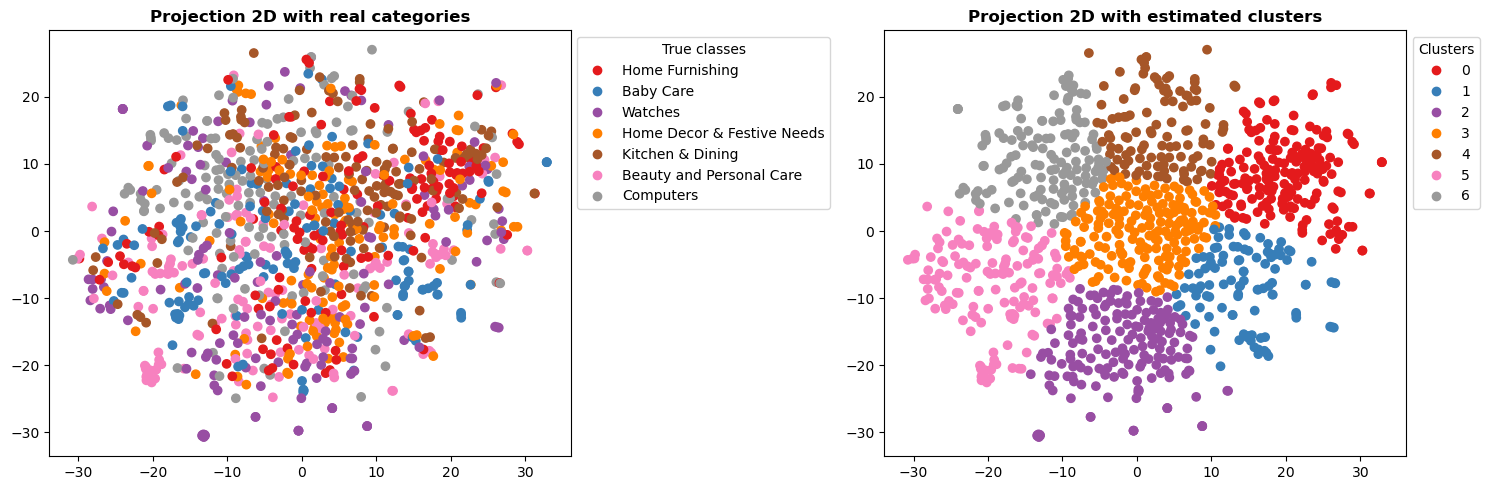

In [17]:
# SIFT labels and clusters
y_true_SIFT = X_SIFT_data["class_encoded"]
y_pred_SIFT = kmeans_SIFT_labels_transform

# Visualisation
Tsne_2D(X_tsne_SIFT,y_true_SIFT,y_pred_SIFT)

- L'approche SIFT donne des clusters intéressants mais pas suffisamment séparés pour qu'on considère la démarche SIFT comme la plus adaptée pour classer les object.
- Le temps d'éxecution de l'algorithme de détection des descripteurs SIFT est également très long(07 min 34s).

###  Matrice de confusion

In [18]:
SIFT_conf_mat = confusion_matrix(X_SIFT_data["class_encoded"], kmeans_SIFT_labels_transform)
print(SIFT_conf_mat)
print()
print(classification_report(X_SIFT_data["class_encoded"], kmeans_SIFT_labels_transform))

[[56  9 21 29 19 12  4]
 [12 29 14 34  9 39 13]
 [19 11 55 11 11 24 19]
 [26 15 34 36 15  8 16]
 [47 10  1 34 31 10 17]
 [14 21 36 16  1 49 13]
 [10 10 12 22 25 11 60]]

              precision    recall  f1-score   support

           0       0.30      0.37      0.34       150
           1       0.28      0.19      0.23       150
           2       0.32      0.37      0.34       150
           3       0.20      0.24      0.22       150
           4       0.28      0.21      0.24       150
           5       0.32      0.33      0.32       150
           6       0.42      0.40      0.41       150

    accuracy                           0.30      1050
   macro avg       0.30      0.30      0.30      1050
weighted avg       0.30      0.30      0.30      1050



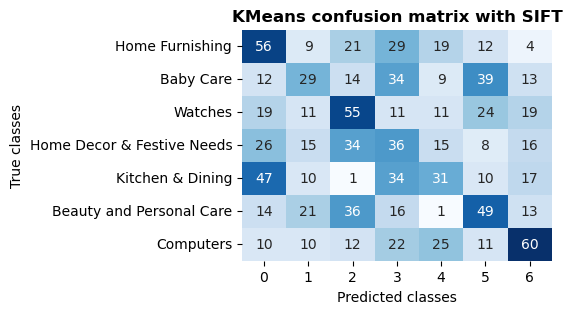

In [19]:
categories = image_data["labels"].unique().tolist()
df_cm_SIFT = pd.DataFrame(SIFT_conf_mat, index = [label for label in categories],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_SIFT, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with SIFT",fontweight="bold")
plt.show()

# III.2. Réseau neuronal convolutif(CNN ou ConvNet)

* Un réseau neuronal convolutif (CNN), également appelé ConvNet, est un type spécialisé d'algorithme d'apprentissage profond principalement conçu pour les tâches qui nécessitent la reconnaissance d'objets, notamment la classification, la détection et la segmentation d'images.

## Transfert learning avec le modèle VGG16 de Keras.

* Le modèle VGG16, développé par Visual Graphics Group de l’Université d’Oxford, est une référence dans le domaine du deep learning. Connu pour sa simplicité et sa profondeur, ce modèle a été un tournant dans la reconnaissance d’images grâce à sa structure convolutive profonde.

In [20]:
# load model
model = VGG16()

# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
temps1 = time.time()
pict_vectors = []
for image_num in range(image_data.shape[0]):
    # load image from dataset
    image = load_img(image_data.image_directory.iloc[image_num], target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape image for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG16 model
    image = preprocess_input(image)
    # get extracted features
    features = model.predict(image)
    print(features.shape)
    pict_vectors.append(features[0])
    image_feature_cnn = pd.DataFrame(pict_vectors)

duration1=time.time()-temps1
print("temps de d'éxecution : ", "%15.2f" % duration1, "secondes")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━

In [22]:
image_feature_cnn

0         1         2         3         4         5         6     \
0     3.398616  0.859573  0.000000  1.106561  2.266124  2.927241  2.446447   
1     0.000000  0.000000  0.000000  1.172009  0.000000  0.000000  0.000000   
2     0.000000  0.000000  0.000000  4.457806  0.000000  0.000000  0.000000   
3     0.000000  0.070989  0.000000  2.046282  0.000000  0.000000  0.000000   
4     3.417153  0.000000  0.000000  0.000000  1.012360  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1045  2.312270  2.432938  0.000000  1.860515  3.101231  2.369040  0.000000   
1046  1.217185  0.365276  0.330849  0.000000  2.140628  0.000000  0.000000   
1047  2.196131  2.398274  2.623641  0.983883  0.366651  0.535508  3.730996   
1048  0.000000  0.000000  0.000000  0.000000  0.000000  0.388865  0.000000   
1049  0.000000  0.000000  0.123133  0.000000  0.342284  0.000000  0.000000   

          7         8         9     ...      4086  4087      4088      4089  \
0     0.000000  0.000000  0.000000  ...  0.485877   0.0  0.000000  0.472937   
1     0.000000  0.000000  6.499797  ...  1.169693   0.0  0.000000  0.000000   
2     0.000000  0.000000  2.820566  ...  0.000000   0.0  0.000000  0.000000   
3     0.000000  0.000000  0.894024  ...  0.000000   0.0  0.000000  0.000000   
4     0.000000  0.000000  0.000000  ...  0.000000   0.0  0.000000  0.000000   
...        ...       ...       ...  ...       ...   ...       ...       ...   
1045  0.000000  1.428848  1.286600  ...  0.000000   0.0  0.058723  0.000000   
1046  0.767265  0.000000  3.563399  ...  0.000000   0.0  0.837411  0.839074   
1047  0.000000  0.000000  0.000000  ...  1.230694   0.0  0.000000  0.000000   
1048  0.000000  0.000000  1.612165  ...  0.974809   0.0  2.205199  2.729846   
1049  1.058403  0.000000  3.060778  ...  0.000000   0.0  0.000000  0.885200   

          4090      4091      4092      4093      4094      4095  
0     0.875755  0.783683  0.000000  0.000000  0.851055  0.000000  
1     0.000000  3.152507  0.000000  0.000000  0.000000  0.000000  
2     0.000000  5.270286  0.000000  1.297101  0.000000  0.000000  
3     0.000000  3.977747  0.000000  0.000000  0.000000  0.000000  
4     0.000000  9.195914  0.139735  0.000000  1.735952  0.000000  
...        ...       ...       ...       ...       ...       ...  
1045  0.000000  0.000000  0.859424  1.085387  0.000000  0.000000  
1046  0.000000  1.042110  0.000000  1.560315  0.000000  0.998342  
1047  0.000000  0.193309  0.546067  2.159873  0.184722  0.000000  
1048  0.000000  0.000000  0.000000  0.000000  0.248330  0.925137  
1049  0.000000  2.335843  0.000000  0.000000  0.527716  2.991750  

[1050 rows x 4096 columns]

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (95%).

In [23]:
print("Dimensions dataset avant réduction PCA : ", image_feature_cnn.shape)
# Instanciate PCA
pca = PCA(n_components=0.95) 
feature_pca_cnn= pca.fit_transform(image_feature_cnn)
print("Dimensions dataset après réduction PCA : ", feature_pca_cnn.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 490)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images
* On utilise les données obtenues avec ACP pour effectuer la réduction T-SNE.

In [24]:
# Instanciate TSNE
tsne = TSNE(n_components=2, perplexity=30,n_iter=2000, init="random", random_state=6)
X_cnn_tsne = tsne.fit_transform(feature_pca_cnn)

# SIFT TSNE Dataset
X_cnn_data = pd.DataFrame(X_cnn_tsne[:,0:2], columns=["tsne1", "tsne2"])
X_cnn_data["class"] = image_data["labels"]
X_cnn_data["class_encoded"] = image_data["labels_encoded"]
print(X_cnn_data.shape)

(1050, 4)


In [25]:
X_cnn_data

tsne1      tsne2            class  class_encoded
0    -22.446419  20.962523  Home Furnishing              4
1    -20.235720   1.751580        Baby Care              0
2    -22.332703  -3.434009        Baby Care              0
3    -27.426195  15.635582  Home Furnishing              4
4    -31.805153  17.620535  Home Furnishing              4
...         ...        ...              ...            ...
1045 -23.254400  20.332739        Baby Care              0
1046  -6.020024   7.131667        Baby Care              0
1047 -16.811703  15.973771        Baby Care              0
1048  -6.873570   6.759046        Baby Care              0
1049  -4.094187   6.627439        Baby Care              0

[1050 rows x 4 columns]

###  Création de clusters à partir du T-SNE calcul su score ARI

In [26]:
# Instanciate KMeans clustering
categories = image_data.labels.value_counts().index.tolist()
kmeans_cnn_tsne = KMeans(n_clusters=len(categories), random_state=42)
kmeans_cnn_tsne.fit(X_cnn_tsne)

KMeans(n_clusters=7, random_state=42)

In [27]:
# confusion matrix for CNN data
conf_mat_CNN = confusion_matrix(X_cnn_data["class_encoded"],kmeans_cnn_tsne.labels_) 
conf_mat_CNN

array([[  8,   1,  25,   1,   1, 111,   3],
       [  6,   8,  13,   0,   1,   5, 117],
       [  0, 110,  37,   0,   1,   1,   1],
       [ 57,   4,  78,   0,   7,   3,   1],
       [ 68,   0,   4,   0,   0,  78,   0],
       [  0,  30,  35,  75,   1,   1,   8],
       [  0,  12,   2,   0, 136,   0,   0]], dtype=int64)

In [28]:
np.argmax(conf_mat_CNN, axis=0)

array([4, 2, 3, 5, 6, 0, 1], dtype=int64)

In [29]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels["y_pred"] = y_pred
    labels["y_pred_transform"] = labels["y_pred"].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

kmeans_CNN_labels_transform = conf_mat_transform(X_cnn_data["class_encoded"], kmeans_cnn_tsne.labels_)

Correspondance des clusters :  [4 2 3 5 6 0 1]


Le score ARI de mesure de similarité est de : 0.451


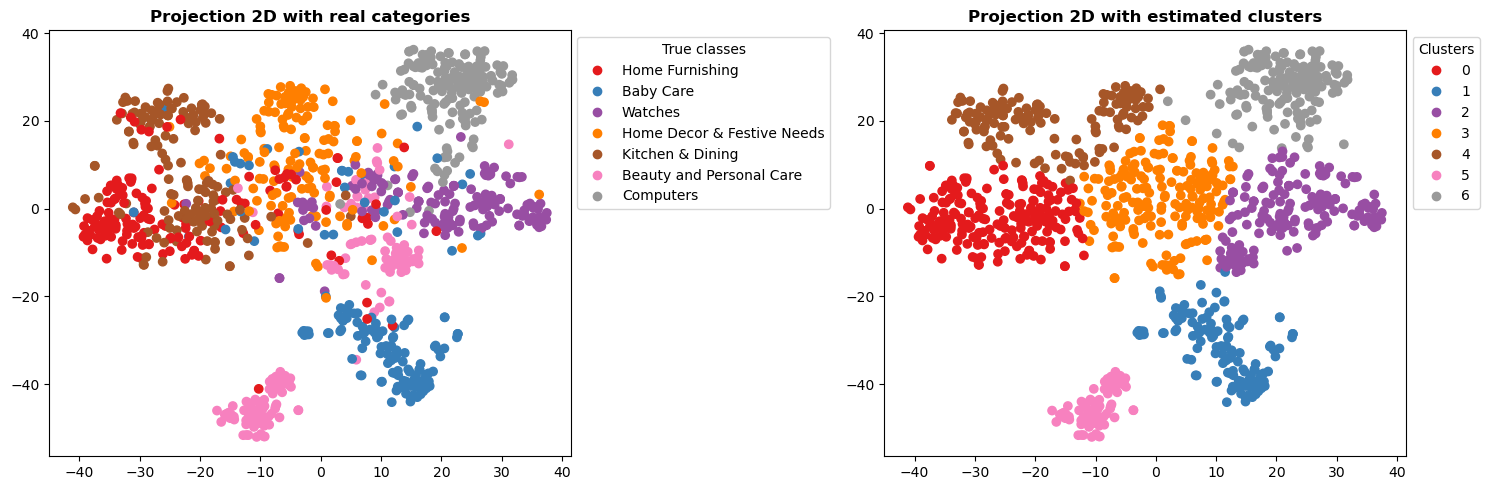

In [30]:
# CNN labels and clusters 
y_true_CNN = X_cnn_data["class_encoded"]
y_pred_CNN = kmeans_CNN_labels_transform

# Tsne 2D for CNN data
Tsne_2D(X_cnn_tsne,y_true_CNN,y_pred_CNN)

- L'approche apprentissage profond par transfert CNN sur les données d'images a l'avantage de donner des clusters mieux séparés parmi toutes les démarches testées, y compris celles sur des données textuelles
- Le temps d'exécution de l'obtention des features images est cependant très long(plus de 13 minutes).
- On observe également une très forte amélioration du score ARI.

### Matrice de confusion

In [31]:
cnn_conf_mat = confusion_matrix(X_cnn_data["class_encoded"], kmeans_CNN_labels_transform)
print(cnn_conf_mat)
print()
print(classification_report(X_cnn_data["class_encoded"], kmeans_CNN_labels_transform))

[[111   3   1  25   8   1   1]
 [  5 117   8  13   6   0   1]
 [  1   1 110  37   0   0   1]
 [  3   1   4  78  57   0   7]
 [ 78   0   0   4  68   0   0]
 [  1   8  30  35   0  75   1]
 [  0   0  12   2   0   0 136]]

              precision    recall  f1-score   support

           0       0.56      0.74      0.64       150
           1       0.90      0.78      0.84       150
           2       0.67      0.73      0.70       150
           3       0.40      0.52      0.45       150
           4       0.49      0.45      0.47       150
           5       0.99      0.50      0.66       150
           6       0.93      0.91      0.92       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



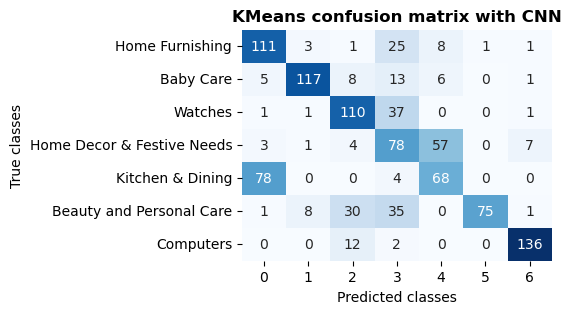

In [32]:
categories = image_data["labels"].unique().tolist()
df_cm_cnn = pd.DataFrame(cnn_conf_mat, index = [label for label in categories],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm_cnn, annot=True,fmt="d",cmap="Blues",cbar=False)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("KMeans confusion matrix with CNN",fontweight="bold")
plt.show()